In [1]:
import torch as th
import numpy as np
from Codes.Losses.snake import Snake
from Codes.Losses.gradImSnake import cmptExtGrad
import torch.nn.functional as F
import networkx as nx
from Codes.Losses.gradImSnake import cmptGradIm, makeGaussEdgeFltr

# Normal Version

In [2]:
# Python
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1F(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline.
    # Here we combine left_pts and right_pts (reversed) to 
    # get a closed polygon without an extra segment.
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks with the computed polygon.
    path = Path(polygon)

    # 4. Compute grid points for the output distance map.
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance for each edge in the polygon.
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # ensures closure
        seg_dist = _distance_to_segmentF(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Set inside (ribbon) points to 0.
    dist_map[is_inside] = 0.0

    # Convert the numpy array to a torch tensor.
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentF(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# V version

In [3]:
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1FV(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D signed distance map where:
             - Negative values inside the ribbon (smallest at centerline)
             - Positive distance to the nearest edge outside
             - Zero at the edges
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks
    path = Path(polygon)

    # 4. Compute grid points for the output distance map
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    # Determine which grid points are inside the ribbon
    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance to each edge in the polygon
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # Ensures closure
        seg_dist = _distance_to_segmentFV(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Apply signed distance: negative inside, positive outside
    dist_map = np.where(is_inside, -dist_map, dist_map)

    # Convert to torch tensor and handle CUDA
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentFV(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# W version

In [4]:
# Python
import torch
import numpy as np
from matplotlib.path import Path

def render_distance_map_2d1FW(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # 1. Compute tangents and normals based on centers
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    normals = np.array(normals)

    # 2. Generate left and right polygon edges
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # Build the polygon that represents the ribbon outline.
    # Here we combine left_pts and right_pts (reversed) to 
    # get a closed polygon without an extra segment.
    polygon = np.vstack([left_pts, right_pts[::-1]])

    # 3. Create a matplotlib Path for inside/outside checks with the computed polygon.
    path = Path(polygon)

    # 4. Compute grid points for the output distance map.
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # 5. Compute distance for each edge in the polygon.
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # ensures closure
        seg_dist = _distance_to_segmentFW(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Convert the numpy array to a torch tensor.
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segmentFW(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# corrected V

In [5]:
import torch
import numpy as np

def ruffy(samples_with_widths, size, normals,iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :return: A 2D distance map where:
             - 0 on the ribbon's left/right edges (width boundaries)
             - Increases outward (outside the ribbon)
             - Increases inward (toward the centerline)
    """
    w, h = size
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    # 1. Extract centers and widths
    centers = np.array([c for c, _ in samples_with_widths], dtype=np.float32)
    widths = np.array([w for _, w in samples_with_widths], dtype=np.float32)
    n_points = len(centers)

    # 3. Generate left/right edges (exclude end caps)
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2

    # 4. Compute distance to left/right edges only (no end caps)
    dist_map = np.full((w, h), np.inf, dtype=np.float32)

    # Left edge segments
    for i in range(n_points - 1):
        p1, p2 = left_pts[i], left_pts[i+1]
        dists = zuffy(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, dists)

    # Right edge segments
    for i in range(n_points - 1):
        p1, p2 = right_pts[i], right_pts[i+1]
        dists = zuffy(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, dists)

    # 5. Convert to torch tensor
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def zuffy(points, seg_p1, seg_p2):
    """Compute distance from points to a line segment defined by seg_p1 and seg_p2."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# new

In [6]:
import torch
import numpy as np
from matplotlib.path import Path

def zoro(samples_with_widths, size, normals,iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :return: A 2D distance map where:
             - 0 on the ribbon's true edges (left/right edges and end caps)
             - Increases outward and inward from the edges
    """
    w, h = size
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # 1. Extract centers and widths
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    n_points = len(centers)
    
    # 3. Generate left/right edges and end caps
    left_pts = centers - normals * widths[:, None] / 2
    right_pts = centers + normals * widths[:, None] / 2
    
    # Initialize distance map with infinity
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    
    # 4. Compute distance to left/right edge segments
    for i in range(n_points - 1):
        # Left edge segment
        p1, p2 = left_pts[i], left_pts[i+1]
        dists = _distance_to_segment(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, dists)
        
        # Right edge segment
        p1, p2 = right_pts[i], right_pts[i+1]
        dists = _distance_to_segment(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, dists)
    
    # 5. Add semicircular end caps
    if n_points >= 1:
        # Start cap (first node)
        start_normal = normals[0]
        start_radius = widths[0] / 2
        start_dists = _distance_to_semicircle(
            grid_points, 
            centers[0], 
            start_radius, 
            start_normal
        ).reshape(h, w).T
        dist_map = np.minimum(dist_map, start_dists)
        
        # End cap (last node)
        end_normal = normals[-1]
        end_radius = widths[-1] / 2
        end_dists = _distance_to_semicircle(
            grid_points, 
            centers[-1], 
            end_radius, 
            end_normal
        ).reshape(h, w).T
        dist_map = np.minimum(dist_map, end_dists)
    
    # 6. Convert to torch tensor
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def _distance_to_segment(points, seg_p1, seg_p2):
    """Distance from points to a line segment"""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

def _distance_to_semicircle(points, center, radius, normal):
    """
    Compute distance to a semicircle aligned with the normal direction.
    - Zero on the semicircle edge
    - Increases inward/outward
    """
    vec_to_center = points - center
    dist_center = np.linalg.norm(vec_to_center, axis=1)
    
    # Angle check: Points must lie in the semicircle's angular range (±90° from normal)
    angles = np.arctan2(vec_to_center[:, 1], vec_to_center[:, 0])
    normal_angle = np.arctan2(normal[1], normal[0])
    angle_diff = np.abs(angles - normal_angle)
    angle_diff = np.minimum(angle_diff, 2 * np.pi - angle_diff)
    
    # Mask for points within the semicircle's angular range
    semicircle_mask = angle_diff <= np.pi / 2
    
    # For points in the semicircle: distance = |dist_center - radius|
    # For others: distance = infinity (ignored)
    dists = np.full(points.shape[0], np.inf)
    dists[semicircle_mask] = np.abs(dist_center[semicircle_mask] - radius)
    
    return dists

# newnew

In [7]:
import torch
import numpy as np
from skimage.draw import polygon
from scipy.spatial.distance import cdist

def zzz(samples_with_widths, size, normals,iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param iscuda: Whether to return a CUDA tensor
    :return: 2D signed distance map where:
             - 0 inside the ribbon
             - Positive values = distance to nearest boundary outside
    """
    w, h = size
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    
    # Extract centerline and widths
    centers = np.array([c for c, _ in samples_with_widths])
    widths = np.array([w for _, w in samples_with_widths])
    
    if len(centers) < 2:
        return torch.zeros(size, dtype=torch.float32)
    
    # Create left/right boundaries
    left_pts = centers - normals * widths[:, None]/2
    right_pts = centers + normals * widths[:, None]/2
    
    # Create polygon coordinates (connect left and right points)
    poly_points = np.vstack([
        left_pts,
        right_pts[::-1],  # Reverse for correct polygon winding
    ])
    
    # 2. Create semicircular end caps ------------------------------------------
    n_segments = 20  # Number of segments for semicircle approximation
    
    # Start cap
    start_normal = normals[0]
    angles = np.linspace(-np.pi/2, np.pi/2, n_segments)
    start_cap = centers[0] + widths[0]/2 * np.column_stack([
        np.cos(angles) * start_normal[0] - np.sin(angles) * start_normal[1],
        np.sin(angles) * start_normal[0] + np.cos(angles) * start_normal[1]
    ])
    
    # End cap
    end_normal = normals[-1]
    angles = np.linspace(np.pi/2, 3*np.pi/2, n_segments)
    end_cap = centers[-1] + widths[-1]/2 * np.column_stack([
        np.cos(angles) * end_normal[0] - np.sin(angles) * end_normal[1],
        np.sin(angles) * end_normal[0] + np.cos(angles) * end_normal[1]
    ])
    
    # Combine all points
    all_points = np.vstack([
        start_cap,
        left_pts,
        end_cap,
        right_pts[::-1]
    ])
    
    # 3. Calculate distance map ------------------------------------------------
    # Create grid coordinates
    x = np.arange(w)
    y = np.arange(h)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Calculate distance to polygon
    distances = cdist(grid_points, all_points).min(axis=1).reshape(w, h)
    
    # Create mask for inside/outside
    rr, cc = polygon(poly_points[:, 0], poly_points[:, 1], (w, h))
    mask = np.zeros((w, h), dtype=bool)
    mask[rr, cc] = True
    
    # Add semicircular areas
    start_mask = (cdist(grid_points, start_cap) < widths[0]/2).any(axis=1).reshape(w, h)
    end_mask = (cdist(grid_points, end_cap) < widths[-1]/2).any(axis=1).reshape(w, h)
    mask = mask | start_mask | end_mask
    
    # Final distance map (0 inside, distance outside)
    dist_map = np.where(mask, 0, distances)
    
    # Convert to tensor
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
        
    return dist_map_t

# perfect

In [3]:
import torch
import numpy as np
from matplotlib.path import Path

def dist_perfectV(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param normals: List of [nx, ny] normal vectors for each sample
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # Extract centers, widths, and normals
    centers = np.array([c for c, _ in samples_with_widths], dtype=np.float32)
    widths = np.array([w for _, w in samples_with_widths], dtype=np.float32)
    normals = np.array(normals, dtype=np.float32)

    if len(centers) == 0:
        # Return a zero tensor if no samples
        dist_map_t = torch.zeros((w, h), dtype=torch.float32)
        return dist_map_t.cuda() if iscuda else dist_map_t

    # Calculate left and right points
    left_pts = centers - (normals * widths[:, None] / 2)
    right_pts = centers + (normals * widths[:, None] / 2)

    # Generate end cap (semicircle at the last sample)
    end_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_end = centers[-1]
        r_end = widths[-1] / 2
        P_end = left_pts[-1]
        Q_end = right_pts[-1]

        dx = P_end[0] - C_end[0]
        dy = P_end[1] - C_end[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20  # Increase for smoother circles
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_end[0] + r_end * np.cos(theta)
        y = C_end[1] + r_end * np.sin(theta)
        end_cap_points = np.column_stack((x, y))[1:-1]  # Exclude P_end and Q_end

    # Generate start cap (semicircle at the first sample)
    start_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_start = centers[0]
        r_start = widths[0] / 2
        P_start = right_pts[0]
        Q_start = left_pts[0]

        dx = P_start[0] - C_start[0]
        dy = P_start[1] - C_start[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_start[0] + r_start * np.cos(theta)
        y = C_start[1] + r_start * np.sin(theta)
        start_cap_points = np.column_stack((x, y))[1:]  # Exclude P_start, include Q_start

    # Build the polygon
    reversed_right_pts = right_pts[::-1]
    if len(reversed_right_pts) > 0:
        reversed_right_pts = reversed_right_pts[1:]  # Skip the first element (Q_end)

    polygon = np.vstack([
        left_pts,
        end_cap_points,
        reversed_right_pts,
        start_cap_points
    ])

    # Create matplotlib Path
    path = Path(polygon)

    # Compute grid points for the output distance map
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    print(grid_points)
    # Check if points are inside the ribbon
    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # Compute distance to all polygon edges
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # Next vertex, with wrap-around
        seg_dist = qq(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Set inside points to negative for V shape
    dist_map = np.where(is_inside, -dist_map, dist_map)

    # Convert to torch tensor
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def qq(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    # treat seg_p1 as the origin, then calculate 
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

In [4]:
import torch
import numpy as np
from matplotlib.path import Path

def dist_perfectW(samples_with_widths, size, normals, iscuda=False):
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param normals: List of [nx, ny] normal vectors for each sample
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon (discarded)
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # Extract centers, widths, and normals
    centers = np.array([c for c, _ in samples_with_widths], dtype=np.float32)
    widths = np.array([w for _, w in samples_with_widths], dtype=np.float32)
    normals = np.array(normals, dtype=np.float32)

    if len(centers) == 0:
        # Return a zero tensor if no samples
        dist_map_t = torch.zeros((w, h), dtype=torch.float32)
        return dist_map_t.cuda() if iscuda else dist_map_t

    # Calculate left and right points
    left_pts = centers - (normals * widths[:, None] / 2)
    right_pts = centers + (normals * widths[:, None] / 2)

    # we just calculate the angle between the center point and the left point of end (usually just 90)
    #then we sample 
    end_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_end = centers[-1]
        r_end = widths[-1] / 2
        P_end = left_pts[-1]
        Q_end = right_pts[-1]

        dx = P_end[0] - C_end[0]
        dy = P_end[1] - C_end[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_end[0] + r_end * np.cos(theta)
        y = C_end[1] + r_end * np.sin(theta)
        end_cap_points = np.column_stack((x, y))[1:-1]  # Exclude P_end and Q_end

    # Generate start cap (semicircle at the first sample)
    start_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_start = centers[0]
        r_start = widths[0] / 2
        P_start = right_pts[0]
        Q_start = left_pts[0]

        dx = P_start[0] - C_start[0]
        dy = P_start[1] - C_start[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_start[0] + r_start * np.cos(theta)
        y = C_start[1] + r_start * np.sin(theta)
        start_cap_points = np.column_stack((x, y))[1:]  # Exclude P_start, include Q_start

    # Build the polygon
    reversed_right_pts = right_pts[::-1]
    if len(reversed_right_pts) > 0:
        reversed_right_pts = reversed_right_pts[1:]  # Skip the first element (Q_end)

    polygon = np.vstack([
        left_pts,
        end_cap_points,
        reversed_right_pts,
        start_cap_points
    ])

    # Create matplotlib Path
    path = Path(polygon)

    # Compute grid points for the output distance map
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    # Check if points are inside the ribbon
    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # Compute distance to all polygon edges
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # Next vertex, with wrap-around
        seg_dist = qq(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Convert to torch tensor
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def qq(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# rib snake start

In [5]:
import matplotlib.pyplot as plt

def show(img,title,graph=None, snake=None, widths=None):   
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    if graph:
        pos = {n:graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray',
                         edge_color='g', font_size=12, font_color='black')
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.show()

In [6]:
def showriba(img, title, graph=None, v_L=None, v_R=None):   
    plt.figure(figsize=(10,10))
    plt.suptitle(title)
    plt.imshow(img)
    
    if graph:
        pos = {n: graph.nodes[n]['pos'][-1::-1] for n in graph.nodes()}
        nx.draw_networkx(graph, pos=pos, node_size=16, node_color='gray', edge_color='g', font_size=12, font_color='black')
    
    if v_L is not None and v_R is not None:
        plt.plot(v_L[:, 1], v_L[:, 0], 'b--', linewidth=1.5, label='Left edge')
        plt.plot(v_R[:, 1], v_R[:, 0], 'g--', linewidth=1.5, label='Right edge')
    
    plt.xlim(0, img.shape[1])
    plt.ylim(img.shape[0], 0)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()

In [7]:
class RibbonSnake(Snake):
    def __init__(self, graph, crop, stepsz, alpha, beta, gimgN, gimgW, step_type="original", ndims=2):
        super().__init__(graph, crop, stepsz, alpha, beta, ndims)
        self.w = th.ones(len(self.s), 1, dtype=th.float32) * 1.0  # Initial width
        self.step_type = step_type
        if self.s.is_cuda:
            self.s = self.s.cuda()
        
        self.gimgN = gimgN  # Gradient image (2 x H x W)
        self.gimgW = gimgW  # Gradient image (2 x H x W)

    def cuda(self):
        super().cuda()
        if self.gimgN is not None:
            self.gimgN = self.gimgN.cuda()
        if self.gimgW is not None:
            self.gimgW = self.gimgW.cuda()
    
    def _compute_normals_complex(self, pos_xy):
        if self.ndims == 2:
            k = pos_xy.size(0)
            normals = th.zeros_like(pos_xy)
            eps = 1e-8  # small constant to avoid division by zero

            # Helper function: rotate a 2D vector 90° (choose clockwise or counterclockwise)
            def perp(vec):
                return th.tensor([-vec[1], vec[0]], dtype=vec.dtype, device=vec.device)

            # First endpoint: use the edge to the next point
            if k >= 2:
                tang = pos_xy[1] - pos_xy[0]
                tang_norm = th.norm(tang) + eps
                tang = tang / tang_norm
                normals[0] = perp(tang)
            
            # Interior points
            for i in range(1, k-1):
                # Edge from previous point and edge to next point
                t1 = pos_xy[i] - pos_xy[i-1]
                t2 = pos_xy[i+1] - pos_xy[i]
                n1 = th.norm(t1) + eps
                n2 = th.norm(t2) + eps
                t1 = t1 / n1
                t2 = t2 / n2

                # Average the two normalized tangents.
                tangent = t1 + t2
                
                # In case the two directions nearly cancel (sharp corner), fall back to one of them.
                if th.norm(tangent) < 1e-5:
                    tangent = t1

                tangent = tangent / (th.norm(tangent) + eps)
                normals[i] = perp(tangent)
            
            # Last endpoint: use the edge from the previous point
            if k >= 2:
                tang = pos_xy[-1] - pos_xy[-2]
                tang = tang / (th.norm(tang) + eps)
                normals[-1] = perp(tang)
        
        elif self.ndims == 3:
            pos_xyz = pos_xy
            k = pos_xyz.size(0)
            normals = th.zeros_like(pos_xyz)
            eps = 1e-8  # small constant to avoid division by zero
            tangents = []
            # First endpoint: use the edge to the next point
            if k >= 2:
                tang = pos_xyz[1] - pos_xyz[0]
                tang_norm = th.norm(tang) + eps
                tang = tang / tang_norm
                tangents.append(tang)
                # Create an arbitrary normal in 3D by taking the cross product with a fixed vector
                arbitrary_vector = th.tensor([1.0, 0.0, 0.0], dtype=tang.dtype, device=tang.device)
                if th.allclose(tang, arbitrary_vector):
                    arbitrary_vector = th.tensor([0.0, 1.0, 0.0], dtype=tang.dtype, device=tang.device)
                normals[0] = th.cross(tang, arbitrary_vector)
                normals[0] = normals[0] / (th.norm(normals[0]) + eps)
            
            # Interior points
            for i in range(1, k-1):
                # Edge from previous point and edge to next point
                t1 = pos_xyz[i] - pos_xyz[i-1]
                t2 = pos_xyz[i+1] - pos_xyz[i]
                n1 = th.norm(t1) + eps
                n2 = th.norm(t2) + eps
                t1 = t1 / n1
                t2 = t2 / n2

                # Average the two normalized tangents.
                tangent = t1 + t2
                
                # In case the two directions nearly cancel (sharp corner), fall back to one of them.
                if th.norm(tangent) < 1e-5:
                    tangent = t1

                tangent = tangent / (th.norm(tangent) + eps)
                tangents.append(tangent)
                # Calculate the perpendicular for the tangent in 3D
                arbitrary_vector = th.tensor([1.0, 0.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                if th.allclose(tangent, arbitrary_vector):
                    arbitrary_vector = th.tensor([0.0, 1.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                normals[i] = th.cross(tangent, arbitrary_vector)
                normals[i] = normals[i] / (th.norm(normals[i]) + eps)
            
            # Last endpoint: use the edge from the previous point
            if k >= 2:
                tang = pos_xyz[-1] - pos_xyz[-2]
                tang = tang / (th.norm(tang) + eps)
                tangents.append(tang)
                arbitrary_vector = th.tensor([1.0, 0.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                if th.allclose(tangent, arbitrary_vector):
                    arbitrary_vector = th.tensor([0.0, 1.0, 0.0], dtype=tangent.dtype, device=tangent.device)
                normals[-1] = th.cross(tang, arbitrary_vector)
                normals[-1] = normals[-1] / (th.norm(normals[-1]) + eps)

        return normals, tangents

    def step(self):
        if len(self.s) == 0:
            return
        super().step(cmptExtGrad(self.s, self.gimgN))
        return self.s
    
    def stiff_step(self, niter):
        if len(self.s) == 0:
            return

        # centerline positions and normals
        pos_xy = self.s
        normals = self._compute_normals_complex(pos_xy)
        
        # calculate edge positions
        v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
        v_R = pos_xy + self.w * normals / 2

        # Sample gradients at edges (2D only)
        grad_L = cmptExtGrad(v_L, self.gimgN) # grad values at left outline
        grad_R = cmptExtGrad(v_R, self.gimgN)

        grad_centerline = cmptExtGrad(pos_xy, self.gimgN)

        # Centerline gradient: sum of edge gradients
        grad_xy = (grad_L - grad_R) * normals

        grad_cent_average = th.mean(grad_centerline, dim=0, keepdim=True)
        grad_xy_average = th.mean(grad_xy, dim=0, keepdim=True)
        # update the centerline according to avergae gradient
        # just shifting the snake
        if niter < 500:
            self.s = self.s - self.stepsz * grad_cent_average
        else:
            self.s = self.s - self.stepsz * grad_xy_average
        #self.s = self.s - self.stepsz * grad_xy
        return self.s

    def comp_second_deriv(self):
        w = self.w
        n = w.shape[0]
        if n < 5:
            grad_norm = th.zeros_like(w)
            if n >= 3:
                grad_norm[1:-1] = (w[:-2] - 2 * w[1:-1] + w[2:])
            return grad_norm

        w_reshaped = w.view(1, 1, -1)
        kernel = th.tensor([1.0, -4.0, 6.0, -4.0, 1.0], dtype=w.dtype, device=w.device).view(1, 1, 5)

        grad_norm = F.conv1d(w_reshaped, kernel, padding=2)
        grad_norm = grad_norm
        return grad_norm.view(-1, 1)
    
    def step_widths(self):
        if len(self.s) == 0:
            return

        if self.ndims == 2:
            # centerline positions and normals
            pos_xy = self.s
            normals = self._compute_normals_complex(pos_xy)
            
            # calculate edge positions
            v_L = pos_xy - self.w * normals / 2 # left outline for ribbon s
            v_R = pos_xy + self.w * normals / 2

            # Sample gradients at edges (2D only)
            grad_L = cmptExtGrad(v_L, self.gimgW) # grad values at left outline
            grad_R = cmptExtGrad(v_R, self.gimgW)

            # Width gradient: projection of (grad_L - grad_R) onto normals
            grad_w = th.sum((-grad_L + grad_R) * normals, dim=1, keepdim=True)

            # smoothing for consecutive width values
            smooth_grad = th.zeros_like(grad_w)
            if len(self.s) > 1:
                smooth_grad[0] = (self.w[0] - self.w[1])
                smooth_grad[1:-1] = (2 * self.w[1:-1] - self.w[:-2] - self.w[2:])
                smooth_grad[-1] = (self.w[-1] - self.w[-2])

            norm_grad = self.comp_second_deriv()
            internal = norm_grad + smooth_grad
            # can also just use self.alpha but need to test to see which one is better (TODO)
            alpha = abs(grad_w) / abs(internal + 1e-8)

            total_grad = grad_w + alpha * internal
            # update width with separate internal energy (simplified version / can add different internal energies for wdith)
            # for example an internal energy that is dependent on width changes
            self.w = self.w - self.stepsz * total_grad
        
        # TODO: 3D case
        elif self.ndims == 3:
            pass

        return self.w

    def optim(self, niter):
        if self.step_type == "stiff":
            for i in range(niter):
                #self.step()
                if i < 300:
                    self.stiff_step(i)
                else:
                    self.step_widths()
        elif self.step_type == "original":
            for i in range(niter):
                if i < 50:
                    self.step()
                else:
                    self.step_widths()
        elif self.step_type == "combined":
            for i in range(niter):
                self.step()
                self.step_widths()
        return self.s
    
    def get_s(self):
        return self.s
    
    def get_w(self):
        return self.w
    
    def set_w(self, w):
        self.w = w

# 3D DIST

In [ ]:
#widths = th.tensor([4.0,5.0,6.0,5.0,4.0,3.0,3.0,2.0,2.0,3.0], dtype=th.float32)

In [13]:
g = nx.Graph()
#widths = th.tensor([8.0]*10,dtype=th.float32)
widths = th.tensor([5.0,5.0,6.0,5.0,4.0,5.0,5.0,5.0,6.0,5.0], dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i, 25]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200), slice(0, 200)]
ndims = 3

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None, ndims=ndims)
s.set_w(widths.clone().detach().view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf, tangents = s._compute_normals_complex(s.s)

centers = np.array([c for c, _ in samples_to_widths], dtype=np.float32)
widths = np.array([w for _, w in samples_to_widths], dtype=np.float32)
normals = np.array(norms_perf, dtype=np.float32)
tangents = np.array(tangents)

def create_circle(center, tangent, radius, normal, num_points=50):
    u = np.cross(tangent, normal)
    u = u / np.linalg.norm(u)    

    angles = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.array([center + radius * (np.cos(a) * u + np.sin(a) * normal)
                              for a in angles])
    return circle_points

circles = []
num_centers = len(centers)

for i in range(num_centers):
    center = centers[i]
    radius = widths[i]
    tangent = tangents[i]
    normal = normals[i]
    
    circle = create_circle(center, tangent, radius, normal)
    circles.append(circle)

    

C:\Users\serta\AppData\Local\Temp\ipykernel_11052\1722180478.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  normals = np.array(norms_perf, dtype=np.float32)


In [10]:
import trimesh

In [14]:
def create_cylinder_mesh(circles):
    """ Generate a cylindrical mesh from a sequence of circles. """
    vertices = np.vstack(circles)
    faces = []

    num_points = circles[0].shape[0]  # Number of points in each circle
    num_circles = len(circles)

    for i in range(num_circles - 1):  # Iterate over adjacent circles
        for j in range(num_points):
            next_j = (j + 1) % num_points  # Wrap around to form a closed loop

            # Define indices for two triangles forming a quad
            v1 = i * num_points + j
            v2 = i * num_points + next_j
            v3 = (i + 1) * num_points + j
            v4 = (i + 1) * num_points + next_j

            faces.append([v1, v2, v3])  # First triangle
            faces.append([v2, v4, v3])  # Second triangle

    return np.array(vertices), np.array(faces)

# Generate mesh from computed circles
vertices, faces = create_cylinder_mesh(circles)

# Create a 3D Trimesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Display the mesh
mesh.show()

In [15]:
def create_hemisphere(center, radius, axis, u, v, num_phi=10, num_theta=50):
    # Ensure inputs are NumPy arrays
    center = np.asarray(center)
    axis = np.asarray(axis)
    u = np.asarray(u)
    v = np.asarray(v)
    
    vertices = []
    faces = []
    # φ varies from 0 (pole) to π/2 (flat face)
    for i in range(num_phi + 1):
        phi = (np.pi / 2) * (i / num_phi)
        current_radius = radius * np.sin(phi)
        offset = radius * np.cos(phi) * axis
        for j in range(num_theta):
            theta = 2 * np.pi * (j / num_theta)
            point = center + offset + current_radius * (np.cos(theta) * u + np.sin(theta) * v)
            vertices.append(point)
    vertices = np.array(vertices)
    
    # Create faces by connecting adjacent rings:
    for i in range(num_phi):
        for j in range(num_theta):
            next_j = (j + 1) % num_theta
            a = i * num_theta + j
            b = i * num_theta + next_j
            c = (i + 1) * num_theta + j
            d = (i + 1) * num_theta + next_j
            faces.append([a, c, b])
            faces.append([b, c, d])
            
    return vertices, np.array(faces)

# Assume you already have:
#   - circles: a list of arrays (each of shape [num_points, 3]) for the cylinder cross-sections.
#   - centers: an array of center positions for each circle.
#   - widths: an array of radii for each circle.
#   - tangents and normals: arrays computed by s._compute_normals_complex(s.s)

# --- Create the hemispherical end-caps ---

# For the start hemisphere (at the beginning of the cylinder):
start_center = centers[0]
start_radius = widths[0]
start_tangent = tangents[0]
start_normal = normals[0]
# Use the same in-plane basis as in your create_circle function:
start_u = np.cross(start_tangent, start_normal)
start_u = start_u / np.linalg.norm(start_u)
start_v = start_normal
# For the start cap, the hemisphere extends opposite to the snake’s tangent:
start_axis = -start_tangent / np.linalg.norm(start_tangent)
hemisphere_start_vertices, hemisphere_start_faces = create_hemisphere(start_center, start_radius, start_axis, start_u, start_v)

# For the end hemisphere (at the end of the cylinder):
end_center = centers[-1]
end_radius = widths[-1]
end_tangent = tangents[-1]
end_normal = normals[-1]
end_u = np.cross(end_tangent, end_normal)
end_u = end_u / np.linalg.norm(end_u)
end_v = end_normal
# For the end cap, the hemisphere extends in the direction of the tangent:
end_axis = end_tangent / np.linalg.norm(end_tangent)
hemisphere_end_vertices, hemisphere_end_faces = create_hemisphere(end_center, end_radius, end_axis, end_u, end_v)

# --- Create the cylinder mesh ---
cylinder_vertices, cylinder_faces = create_cylinder_mesh(circles)

# --- Combine the meshes ---
# We assume that the hemisphere equators exactly match the cylinder’s start and end circles.
# To combine, we offset the face indices appropriately.
hemisphere_start_faces_offset = hemisphere_start_faces + len(cylinder_vertices)
hemisphere_end_faces_offset = hemisphere_end_faces + len(cylinder_vertices) + len(hemisphere_start_vertices)

combined_vertices = np.vstack([cylinder_vertices, hemisphere_start_vertices, hemisphere_end_vertices])
combined_faces = np.vstack([cylinder_faces, hemisphere_start_faces_offset, hemisphere_end_faces_offset])

# Create a trimesh object and display it:
mesh = trimesh.Trimesh(vertices=combined_vertices, faces=combined_faces)
mesh.show()

In [ ]:
min_bounds, max_bounds = mesh.bounds  # mesh is your trimesh.Trimesh object
margin = 10.0  # optional extra margin around the object

# Define grid resolution (adjust as needed)
nx, ny, nz = 100, 100, 100
x = np.linspace(min_bounds[0] - margin, max_bounds[0] + margin, nx)
y = np.linspace(min_bounds[1] - margin, max_bounds[1] + margin, ny)
z = np.linspace(min_bounds[2] - margin, max_bounds[2] + margin, nz)
grid_x, grid_y, grid_z = np.meshgrid(x, y, z, indexing='ij')
grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()])

# Compute signed distances (negative inside, positive outside)
distance_field = trimesh.proximity.signed_distance(mesh, grid_points)

# Reshape the flat distance array back into a 3D grid
distance_field = distance_field.reshape((nx, ny, nz))

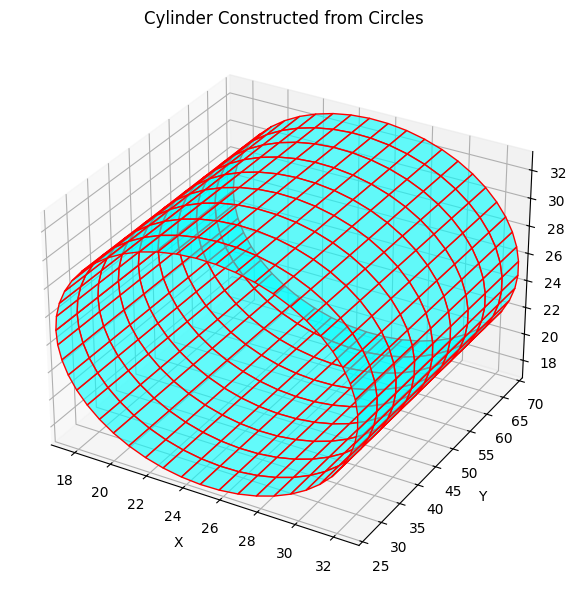

In [92]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Stack circles into an array of shape (N, M, 3)
circles_array = np.stack(circles, axis=0)  # shape: (N, M, 3)
N, M, _ = circles_array.shape

# Build faces by connecting consecutive circles
faces = []
for i in range(N - 1):
    for j in range(M):
        # Wrap around at the end of the circle
        next_j = (j + 1) % M
        # Each face is a quadrilateral connecting two adjacent circles
        face = [circles_array[i, j],
                circles_array[i+1, j],
                circles_array[i+1, next_j],
                circles_array[i, next_j]]
        faces.append(face)

# Create the 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Create a Poly3DCollection for the cylinder surface
poly = Poly3DCollection(faces, facecolors='cyan', edgecolors='r', alpha=0.6)
ax.add_collection3d(poly)

# Extract all points to determine the plot limits
all_points = circles_array.reshape(-1, 3)
x_limits = (np.min(all_points[:, 0]), np.max(all_points[:, 0]))
y_limits = (np.min(all_points[:, 1]), np.max(all_points[:, 1]))
z_limits = (np.min(all_points[:, 2]), np.max(all_points[:, 2]))

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_zlim(z_limits)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Cylinder Constructed from Circles')
plt.tight_layout()
plt.show()

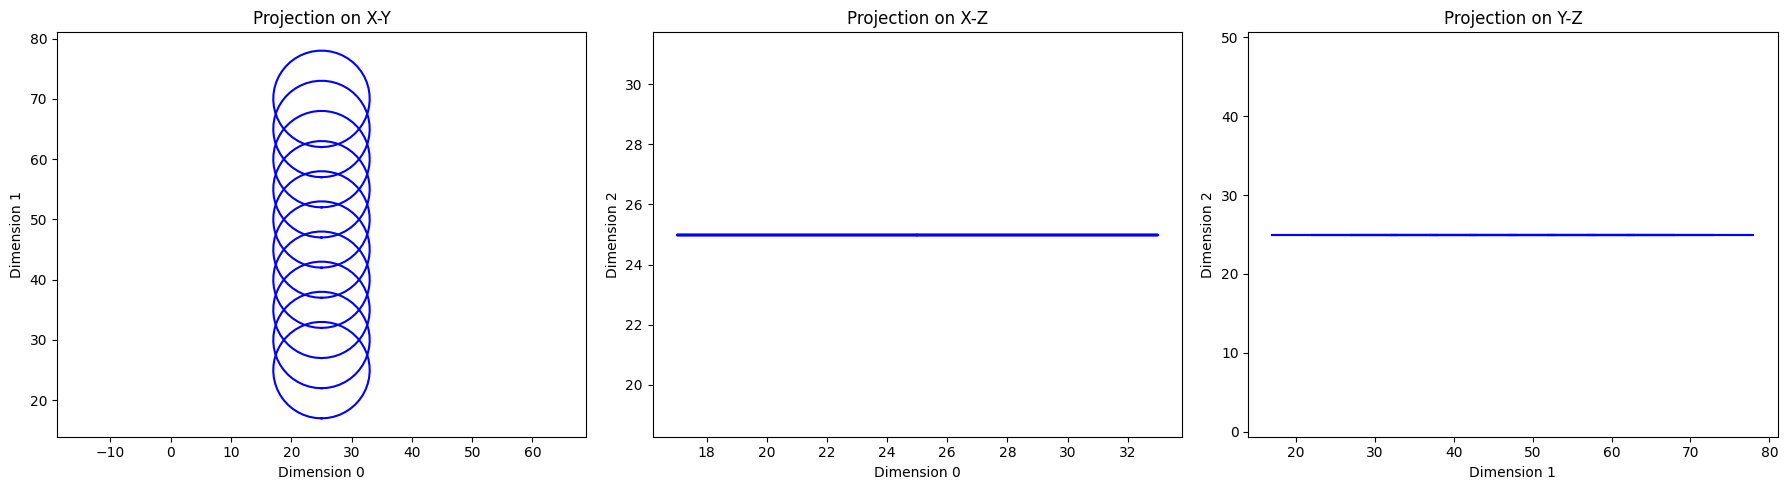

In [71]:
dim_pairs = [(0, 1), (0, 2), (1, 2)]
titles = ["Projection on X-Y", "Projection on X-Z", "Projection on Y-Z"]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for ax, (i, j), title in zip(axs, dim_pairs, titles):
    for circle in circles:
        # Project the circle points on the i-th and j-th dimensions.
        ax.plot(circle[:, i], circle[:, j], 'b-')
    ax.set_xlabel(f"Dimension {i}")
    ax.set_ylabel(f"Dimension {j}")
    ax.set_title(title)
    ax.axis("equal")

plt.tight_layout()
plt.show()

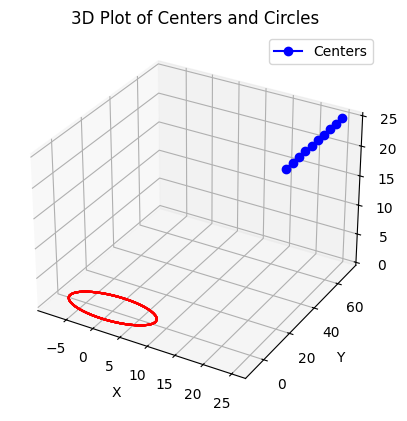

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, z coordinates from centers
centers_x = centers[:, 0]
centers_y = centers[:, 1]
centers_z = centers[:, 2]

# Plot the centers
ax.plot(centers_x, centers_y, centers_z, 'bo-', label='Centers')

# Plot the circles
for circle in circles:
    ax.plot(circle[:, 0], circle[:, 1], circle[:, 2], 'r-')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Centers and Circles')
ax.legend()

plt.show()

In [ ]:
for idx, normals in enumerate(normals):
    circles[idx] = circles[idx] * normals + centers[idx]

In [56]:
circ = circles[0] + centers[0] * normals[0]

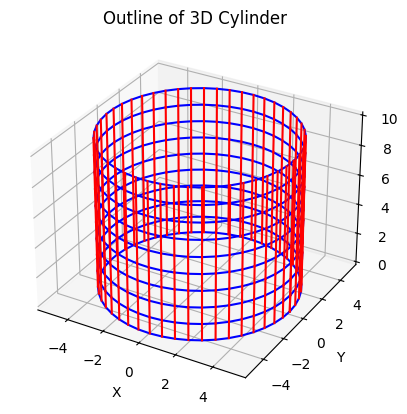

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cylinder parameters
radius = 5
height = 10
num_points = 50  # Points per disc
num_layers = 10  # Number of disc layers

# Generate circle points in 3D space
theta = np.linspace(0, 2 * np.pi, num_points)
x = radius * np.cos(theta)
y = radius * np.sin(theta)

# Generate different layers along the z-axis
z_values = np.linspace(0, height, num_layers)

# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot disc outlines
for z in z_values:
    ax.plot(x, y, z, 'b')  # Outline of each disc

# Connect corresponding points to form cylinder edges
for i in range(num_points):
    for j in range(num_layers - 1):
        ax.plot([x[i], x[i]], [y[i], y[i]], [z_values[j], z_values[j+1]], 'r')  # Vertical lines

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Outline of 3D Cylinder")

plt.show()

In [ ]:
import torch
import numpy as np
from matplotlib.path import Path

def dist_perfect3DW(samples_with_widths, size, normals, iscuda=False):
    """
    We will try to create a shape that represents the ribbon snake first
    Each node will have a disc it creates with the normal of that node and width
    After creating these they will be joined to create the cylinder that will be the ribbon snake
    First and last nodes will have semi-circles
    
    """
    """
    :param samples_with_widths: List of (center, width), where
                                center is [cx, cy], width is scalar
    :param size: (width, height) of output 2D image
    :param normals: List of [nx, ny] normal vectors for each sample
    :param iscuda: Whether to return a CUDA tensor
    :return: A 2D distance map where:
             - 0 inside the ribbon
             - Euclidean distance to the nearest edge outside
    """
    w, h = size

    # Extract centers, widths, and normals
    centers = np.array([c for c, _ in samples_with_widths], dtype=np.float32)
    widths = np.array([w for _, w in samples_with_widths], dtype=np.float32)
    normals = np.array(normals, dtype=np.float32)

    if len(centers) == 0:
        # Return a zero tensor if no samples
        dist_map_t = torch.zeros((w, h), dtype=torch.float32)
        return dist_map_t.cuda() if iscuda else dist_map_t

    # Calculate left and right points
    left_pts = centers - (normals * widths[:, None] / 2)
    right_pts = centers + (normals * widths[:, None] / 2)

    theta = np.linspace(0, 2 * np.pi, num_points)
    circlex = centers[0] + (normals * widths[:, None] * np.cos(theta))
    
    # we just calculate the angle between the center point and the left point of end (usually just 90)
    #then we sample 
    end_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_end = centers[-1]
        r_end = widths[-1] / 2
        P_end = left_pts[-1]
        Q_end = right_pts[-1]

        dx = P_end[0] - C_end[0]
        dy = P_end[1] - C_end[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_end[0] + r_end * np.cos(theta)
        y = C_end[1] + r_end * np.sin(theta)
        end_cap_points = np.column_stack((x, y))[1:-1]  # Exclude P_end and Q_end

    # Generate start cap (semicircle at the first sample)
    start_cap_points = np.zeros((0, 2), dtype=np.float32)
    if len(centers) > 0:
        C_start = centers[0]
        r_start = widths[0] / 2
        P_start = right_pts[0]
        Q_start = left_pts[0]

        dx = P_start[0] - C_start[0]
        dy = P_start[1] - C_start[1]
        start_angle = np.arctan2(dy, dx)
        end_angle = start_angle + np.pi

        num_segments = 20
        theta = np.linspace(start_angle, end_angle, num_segments + 1)
        x = C_start[0] + r_start * np.cos(theta)
        y = C_start[1] + r_start * np.sin(theta)
        start_cap_points = np.column_stack((x, y))[1:]  # Exclude P_start, include Q_start

    # Build the polygon
    reversed_right_pts = right_pts[::-1]
    if len(reversed_right_pts) > 0:
        reversed_right_pts = reversed_right_pts[1:]  # Skip the first element (Q_end)

    polygon = np.vstack([
        left_pts,
        end_cap_points,
        reversed_right_pts,
        start_cap_points
    ])

    # Create matplotlib Path
    path = Path(polygon)

    # Compute grid points for the output distance map
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    # Check if points are inside the ribbon
    is_inside = path.contains_points(grid_points).reshape(h, w).T

    # Compute distance to all polygon edges
    dist_map = np.full((w, h), np.inf, dtype=np.float32)
    num_vertices = polygon.shape[0]
    for i in range(num_vertices):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % num_vertices]  # Next vertex, with wrap-around
        seg_dist = qq(grid_points, p1, p2).reshape(h, w).T
        dist_map = np.minimum(dist_map, seg_dist)

    # Convert to torch tensor
    dist_map_t = torch.from_numpy(dist_map).float()
    if iscuda:
        dist_map_t = dist_map_t.cuda()
    return dist_map_t

def qq(points, seg_p1, seg_p2):
    """Compute distance from array of points to a line segment."""
    seg_vec = seg_p2 - seg_p1
    seg_len = np.linalg.norm(seg_vec)
    if seg_len < 1e-8:
        return np.linalg.norm(points - seg_p1, axis=1)
    
    t = np.dot(points - seg_p1, seg_vec) / (seg_len ** 2)
    t = np.clip(t, 0, 1)
    proj = seg_p1 + t[:, None] * seg_vec
    return np.linalg.norm(points - proj, axis=1)

# Basic Example

C:\Users\serta\AppData\Local\Temp\ipykernel_12676\3027360664.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


[[ 0  0]
 [ 1  0]
 [ 2  0]
 ...
 [97 99]
 [98 99]
 [99 99]]


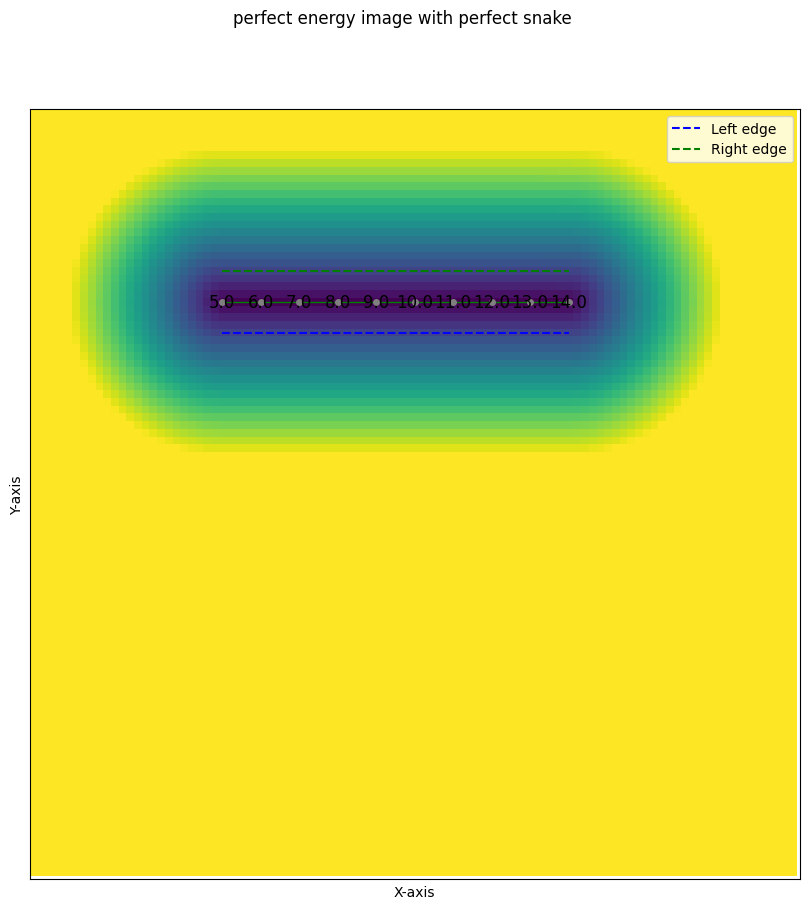

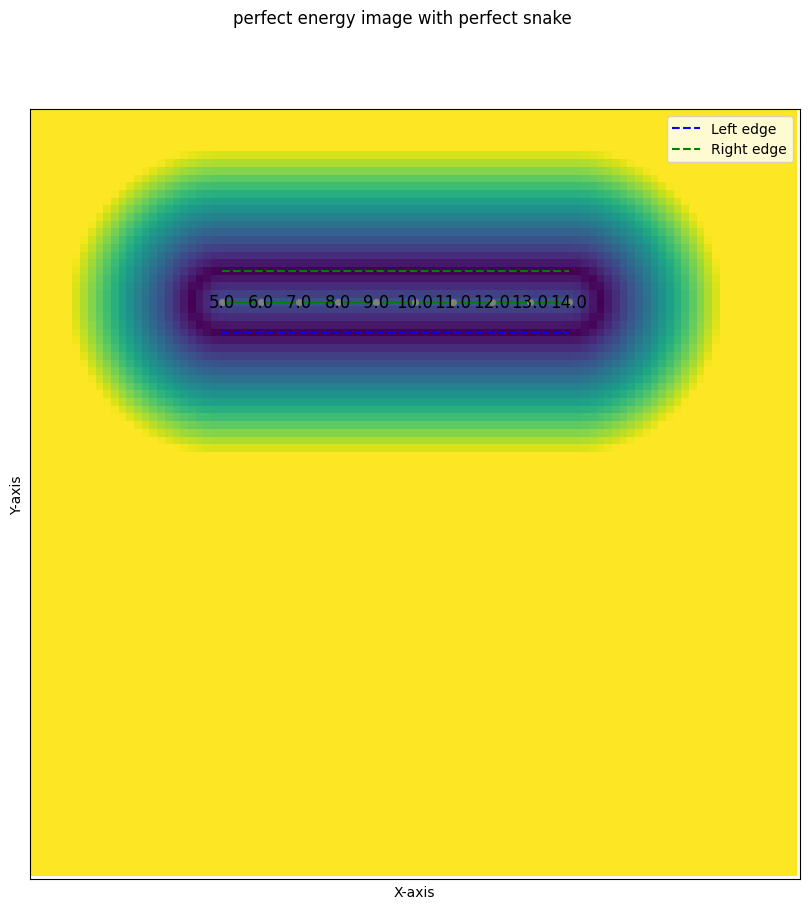

In [9]:
g = nx.Graph()
#widths = th.tensor([4.0,5.0,6.0,5.0,4.0,3.0,3.0,2.0,2.0,3.0], dtype=th.float32)
widths = th.tensor([8.0]*10,dtype=th.float32)
# az samplelayınca ve 
for i in range(25,75, 5):  # Start from 0
    g.add_node(i/5, pos=np.array([25, i]))
    if i > 25:
        g.add_edge(i/5, i/5 - 1)
        
stepsz = 0.33
# if alpha is > 0, and sampling is not done enough, snake will collapse in itself
alpha = 0.0
beta = 0.0
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s)

dismap1V = dist_perfectV(samples_to_widths, [100, 100], norms_perf)
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
dismap1V = torch.clamp(dismap1V, max=16)
dis_abs = torch.abs(dismap1V)

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(dismap1V.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)
showriba(dis_abs.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

#del s

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([10,0])

predv =dismap1V.clone()[None,None]
predw = dis_abs.clone()[None,None]

In [14]:
orig_dist_map = s.renderDistanceMap(size,cropsz,dmax,maxedge)
pred_orig = orig_dist_map.clone()[None,None]

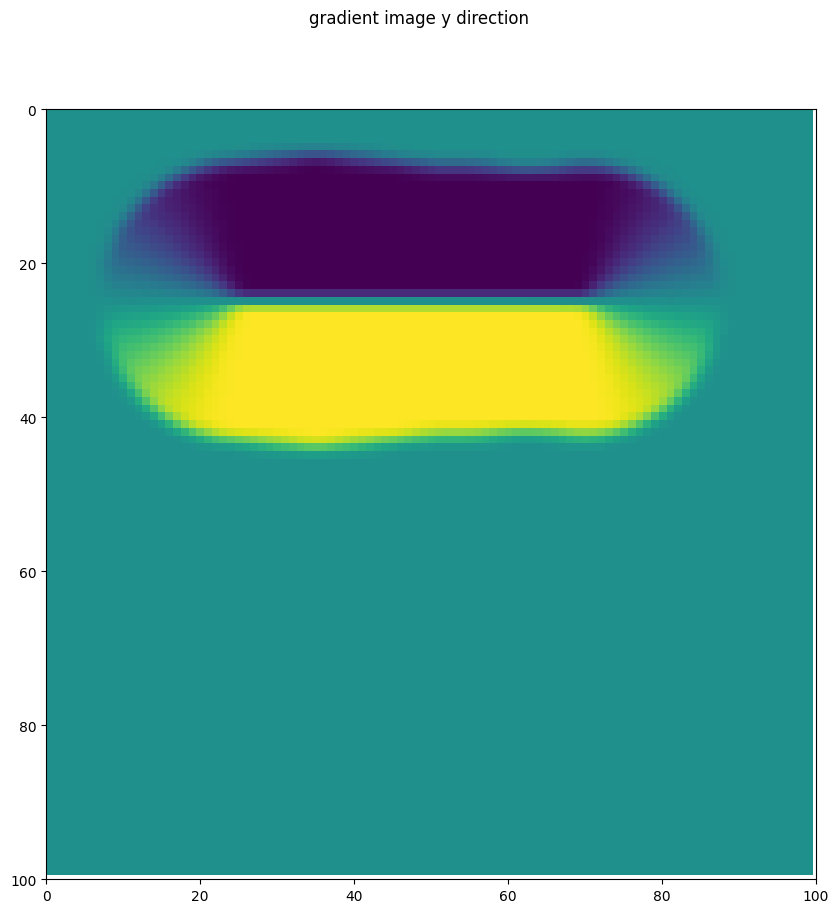

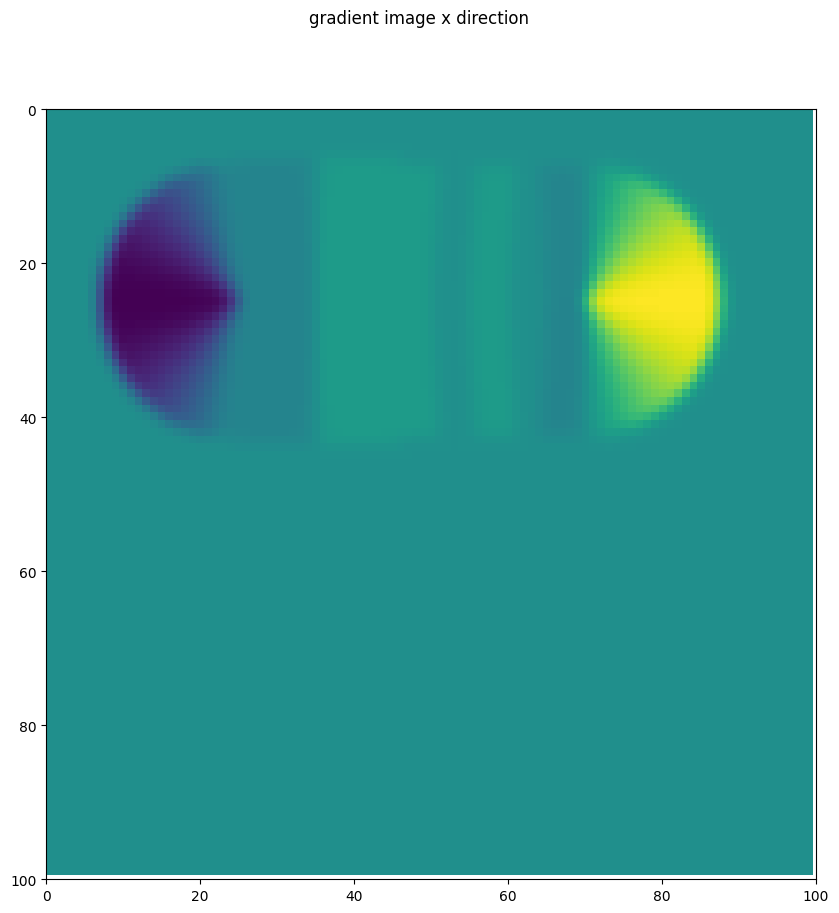

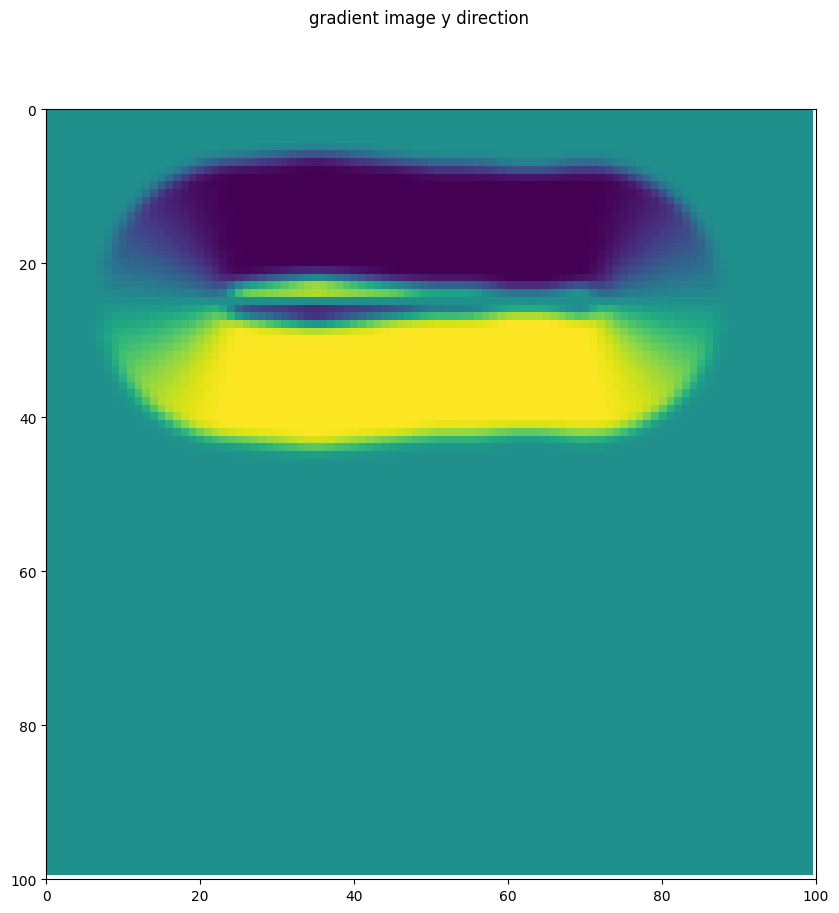

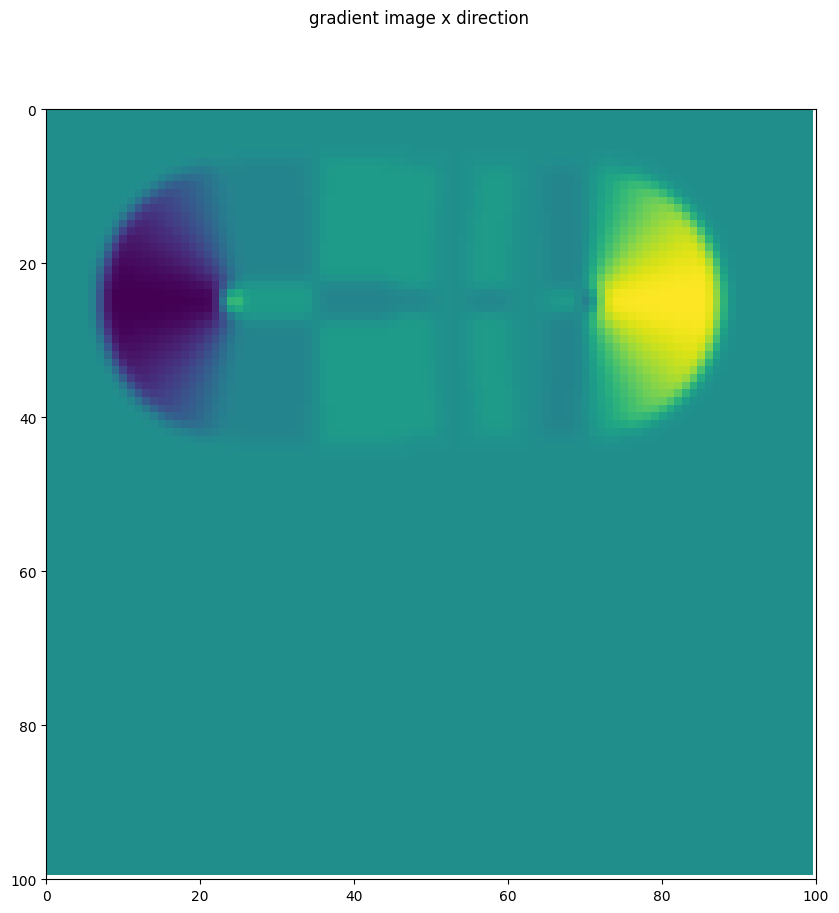

In [31]:
fltr = makeGaussEdgeFltr(1.0,2)
fltrtr = th.from_numpy(fltr).type(th.float32)

gimgv = cmptGradIm(predv,fltrtr)
gimgw = cmptGradIm(predw,fltrtr)
gimg = cmptGradIm(pred_orig,fltrtr)

show(gimgv[0][0].detach().numpy(),"gradient image y direction")
show(gimgv[0][1].detach().numpy(),"gradient image x direction")

""" show((gimg[0][0] - gimgv[0][0]).detach().numpy(), "diff1")
show((gimg[0][1] - gimgv[0][1]).detach().numpy(), "diff2")
diff1 = gimg[0][0] - gimgv[0][0]
diff2 = gimg[0][1] - gimgv[0][1] """

extgradfac=1.0
gimgv = gimgv[0]
gimgw = gimgw[0]

show(gimgw[0].detach().numpy(),"gradient image y direction")
show(gimgw[1].detach().numpy(),"gradient image x direction")

croprib=[slice(0,200), slice(0,200)]

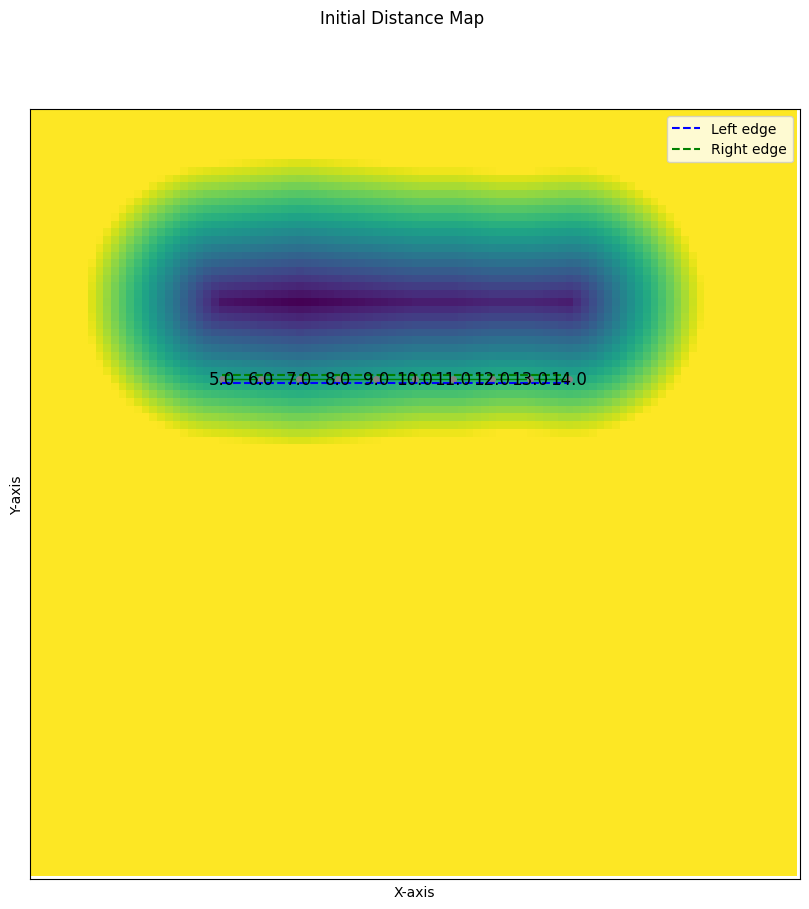

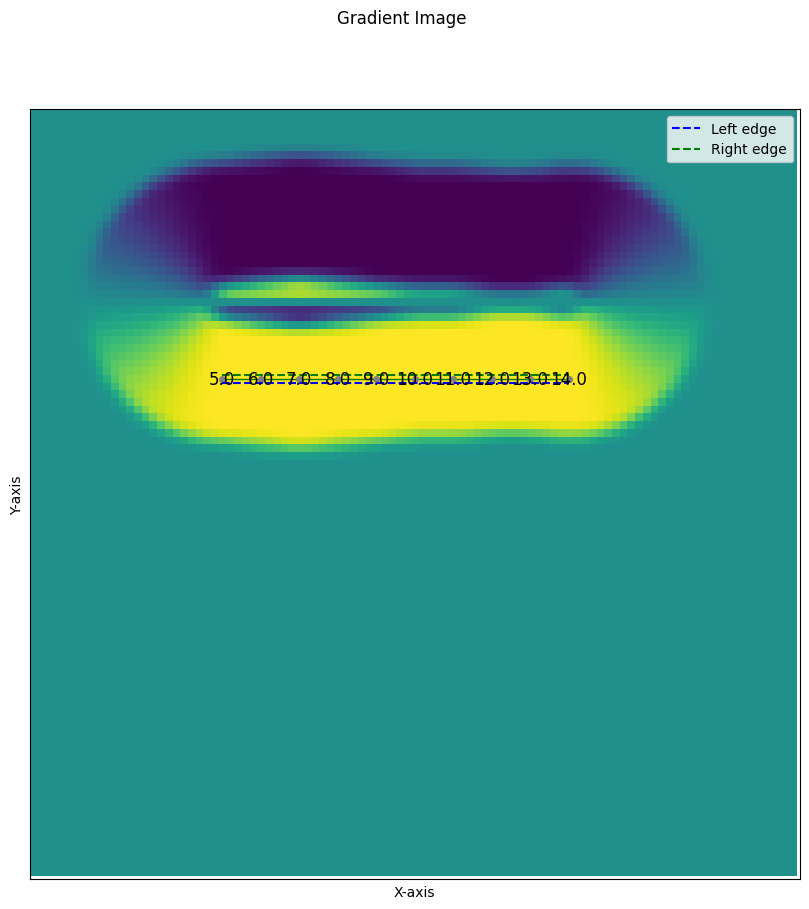

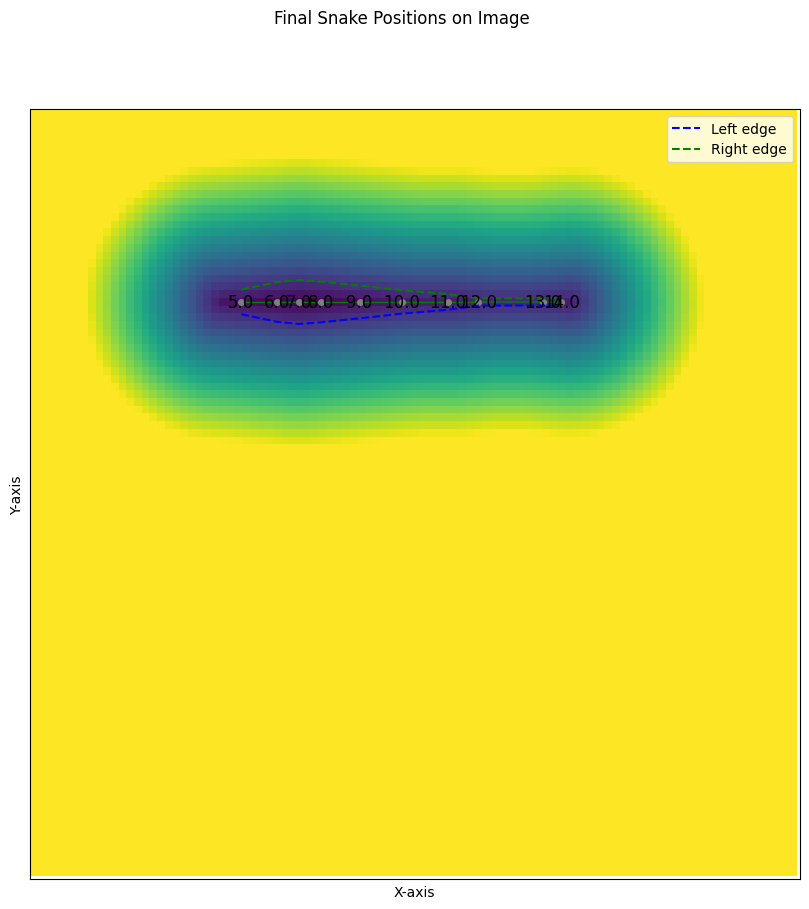

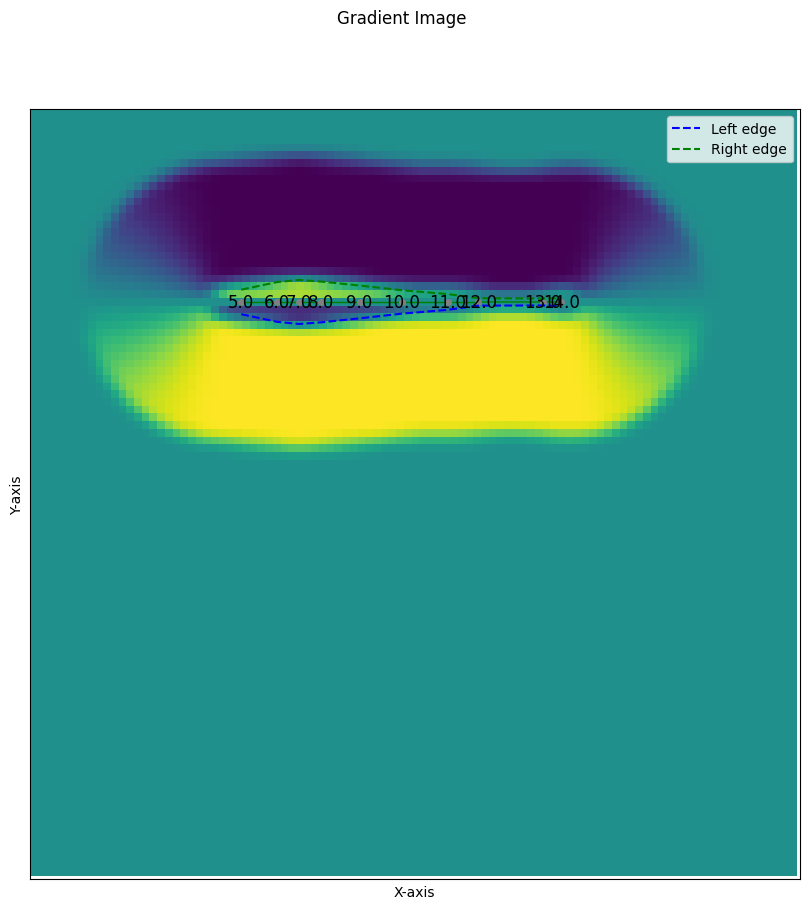

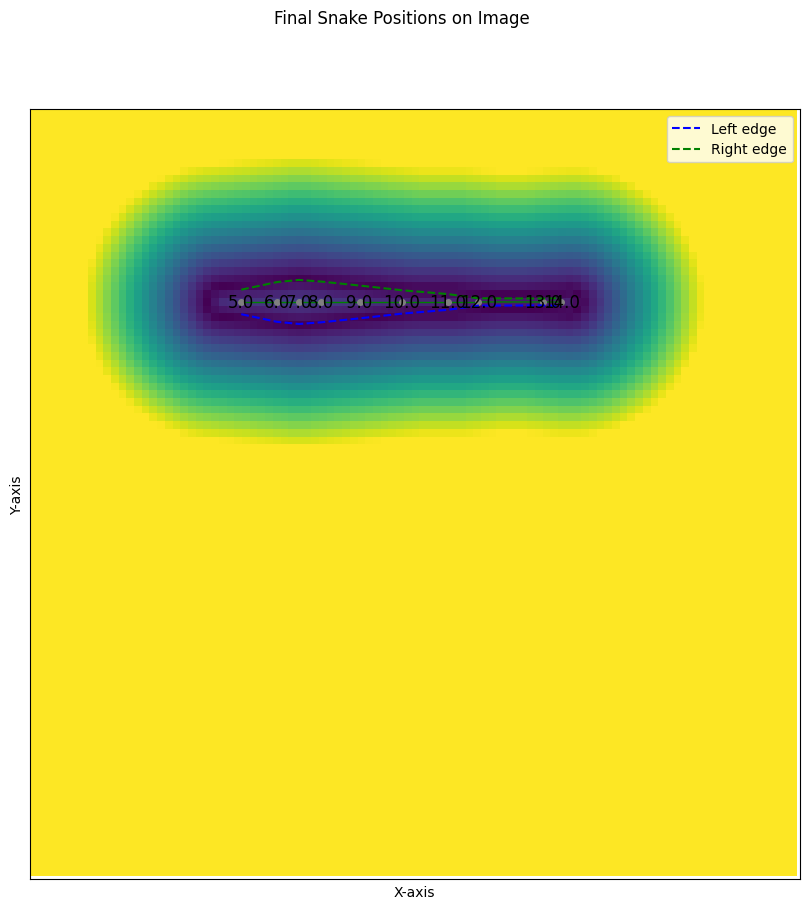

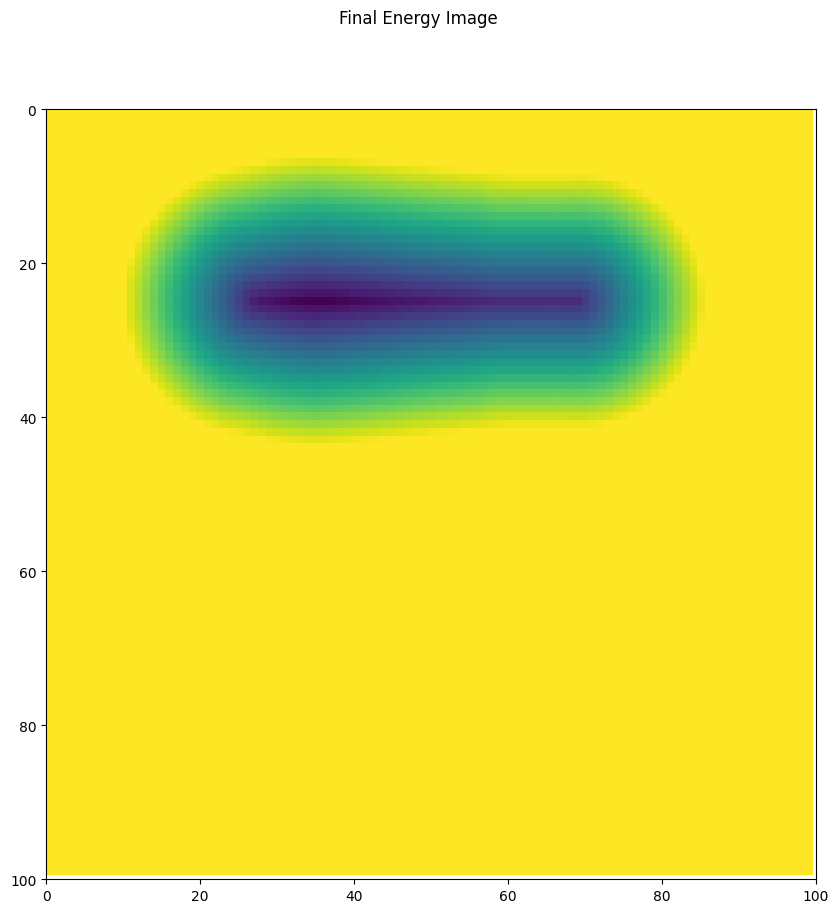

In [32]:
sa=RibbonSnake(g,croprib,stepsz,alpha,beta,gimgv, gimgw, step_type="original")
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sa._compute_normals_complex(sa.s)
v_L_prev = (sa.s - sa.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sa.s + sa.w * norms_prev / 2).detach().cpu().numpy()
showriba(predv[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sa.getGraph(), v_L_prev, v_R_prev)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L_prev, v_R_prev)

last = sa.optim(150)
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)

# Get the final positions of the snake nodes
final_positions = sa.get_s().detach().cpu().numpy()
norms = sa._compute_normals_complex(sa.s)
v_L = (sa.s - sa.w * norms / 2).detach().cpu().numpy()
v_R = (sa.s + sa.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(predv[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph(), v_L, v_R)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image', sa.getGraph(), v_L, v_R)
showriba(predw[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sa.getGraph(), v_L, v_R)

gra = sa.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = sa.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))
dis_final = dist_perfectV(samples_to_widths, [100, 100], norms)
dis_final = torch.clamp(dis_final, max=16)
show(dis_final.detach().cpu().numpy(), 'Final Energy Image')

# ----------------------

# Weird Example

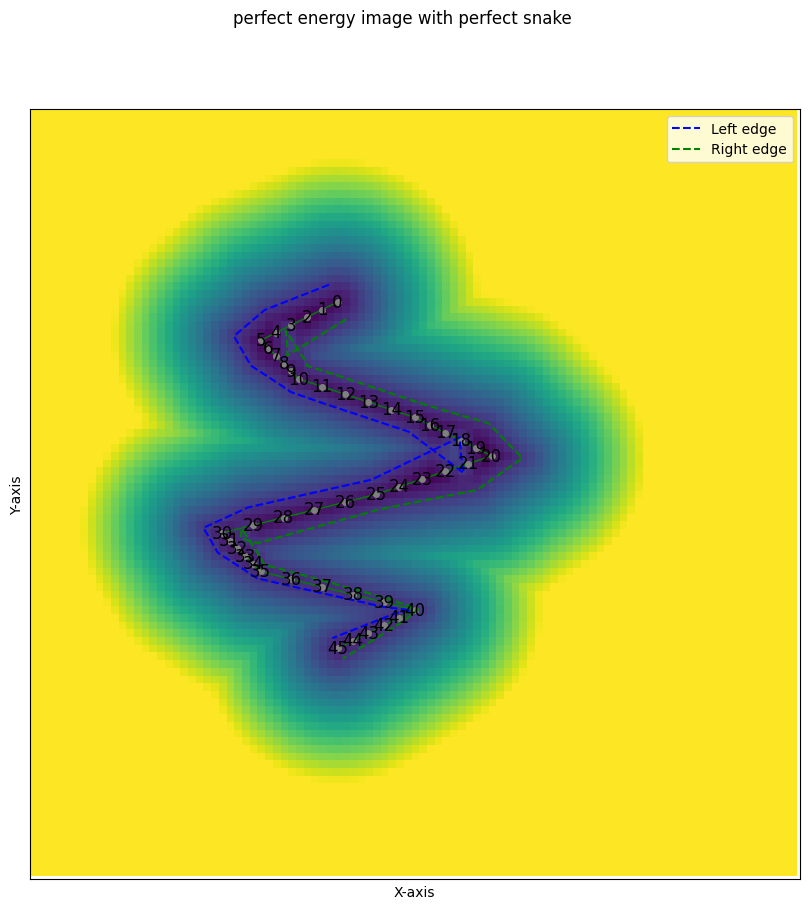

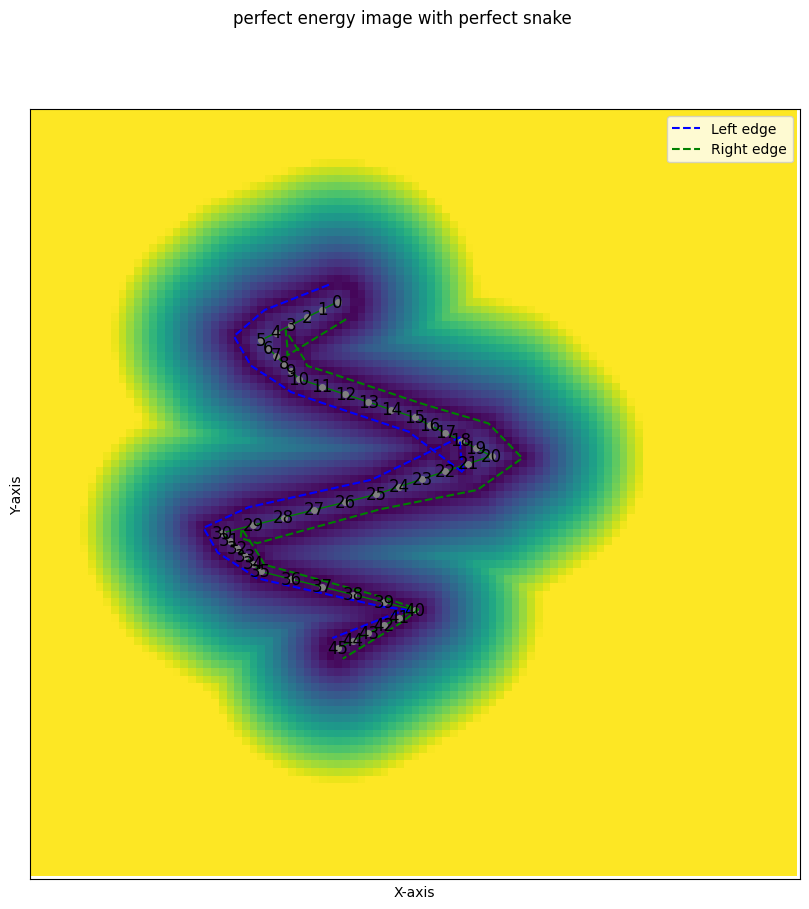

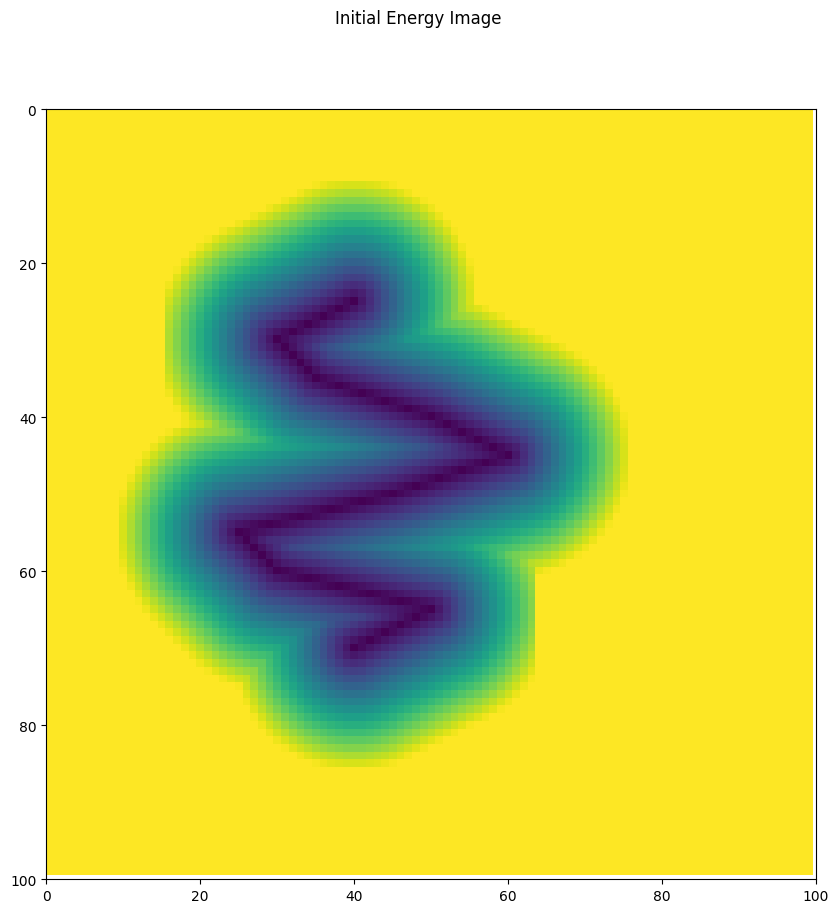

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


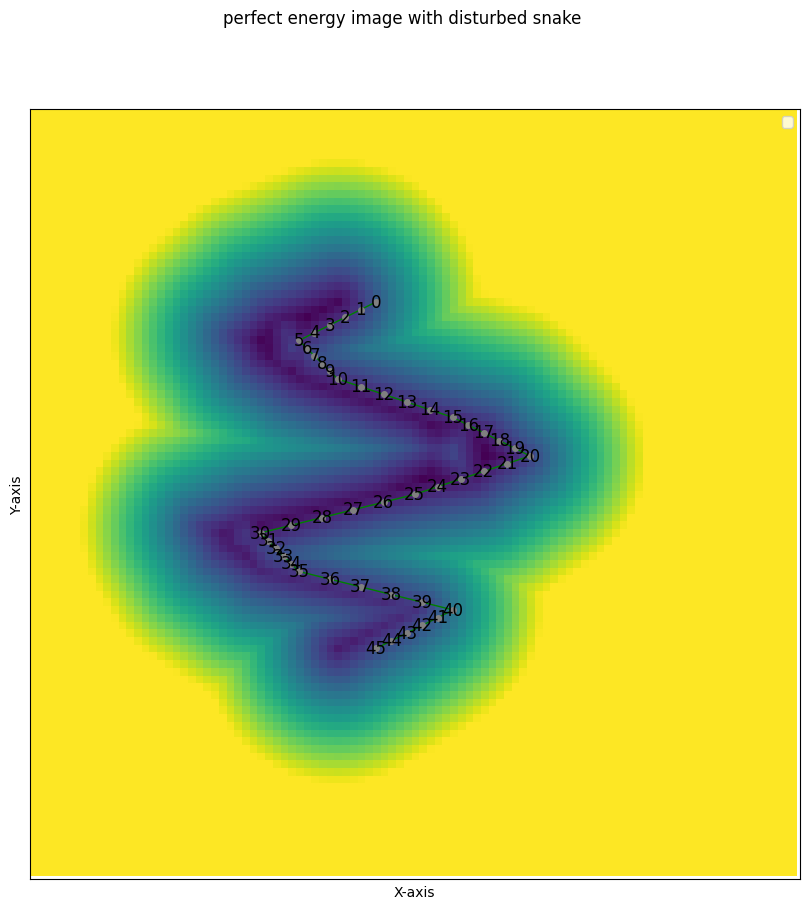

In [37]:
node_positions = [
    (25, 40), (30, 30), (35, 35), (40, 50),
    (45, 60), (50, 45), (55, 25), (60, 30),
    (65, 50), (70, 40)
]
widths = [5, 7, 4, 4, 8, 4, 5, 2, 1, 3]

g = nx.Graph()

node_index = 0

g.add_node(node_index, pos=np.array(node_positions[0]), width=widths[0])
last_node_index = node_index

for i in range(len(node_positions) - 1):
    start_pos = np.array(node_positions[i])
    end_pos = np.array(node_positions[i + 1])
    start_width = widths[i]
    end_width = widths[i + 1]
    
    for j in range(1, 5):
        fraction = j / 5
        pos = start_pos + fraction * (end_pos - start_pos)
        width_val = start_width + fraction * (end_width - start_width)
        node_index += 1
        g.add_node(node_index, pos=pos, width=width_val)
        g.add_edge(last_node_index, node_index)
        last_node_index = node_index
        
    node_index += 1
    g.add_node(node_index, pos=np.array(node_positions[i + 1]), width=end_width)
    g.add_edge(last_node_index, node_index)
    last_node_index = node_index

""" for idx, pos in enumerate(node_positions):
    g.add_node(idx, pos=np.array(pos), width=widths[idx])
    if idx > 0:
        g.add_edge(idx, idx - 1) """

widths_array = [g.nodes[node]['width'] for node in g.nodes()]

stepsz = 0.33
alpha = 0.0001
beta = 0.1
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths_array, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

dismap1V = dist_perfectV(samples_to_widths, [100, 100], s._compute_normals_complex(s.s))
dismap1V = torch.clamp(dismap1V, max=16)
dismap1W = torch.abs(dismap1V)

norms = s._compute_normals_complex(s.s)
v_L_prev = (s.s - s.w * norms / 2).detach().cpu().numpy()
v_R_prev = (s.s + s.w * norms / 2).detach().cpu().numpy()
# for the values in distance map, if a value is higher than 16 I want it to automatically set to 16
showriba(dismap1V.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_prev, v_R_prev)
showriba(dismap1W.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_prev, v_R_prev)
size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4


dis = s.renderDistanceMap(size, cropsz, dmax, maxedge)
show(dis.detach().cpu().numpy(), 'Initial Energy Image')
pred_dis = dis.clone()[None, None]
#del s

""" disturbances = [
    (0, 5), (0, -3), (0, 7), (0, 0), (0, 6), 
    (0, 1), (0, 7), (0, 2), (0, -5), (0, 1)
]

for i, pos in enumerate(disturbances):
    g.nodes[i]["pos"] += np.array(pos) """

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([0,5])

predV = dismap1V.clone()[None, None]
predW = dismap1W.clone()[None, None]

showriba(predV[0,0].detach().numpy(), "perfect energy image with disturbed snake", g)

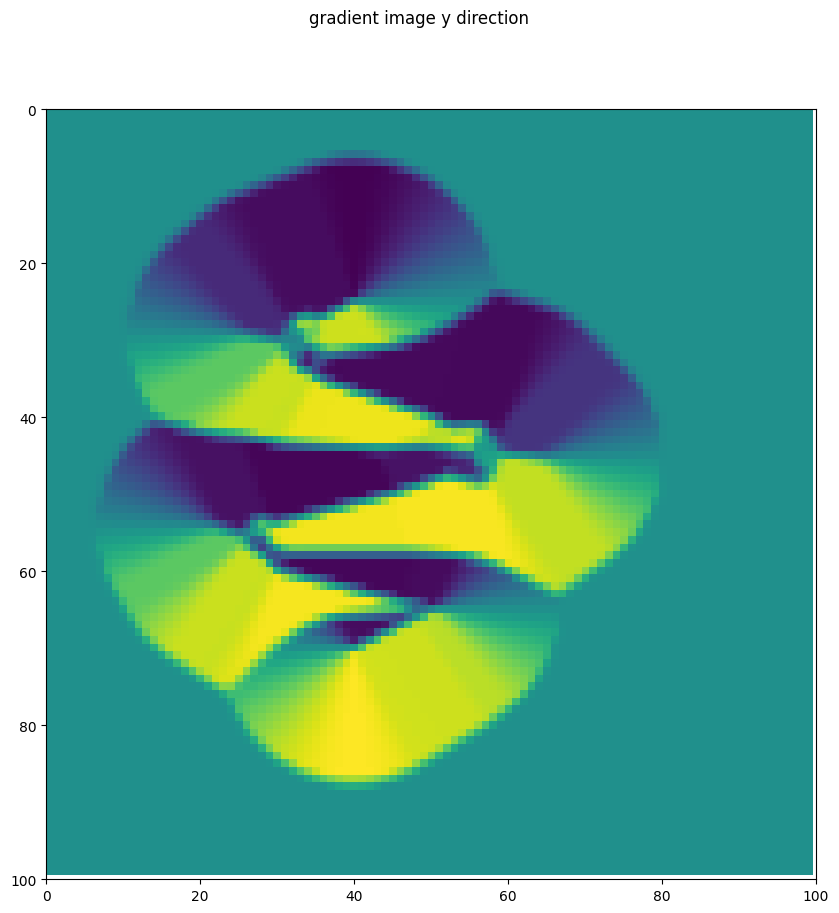

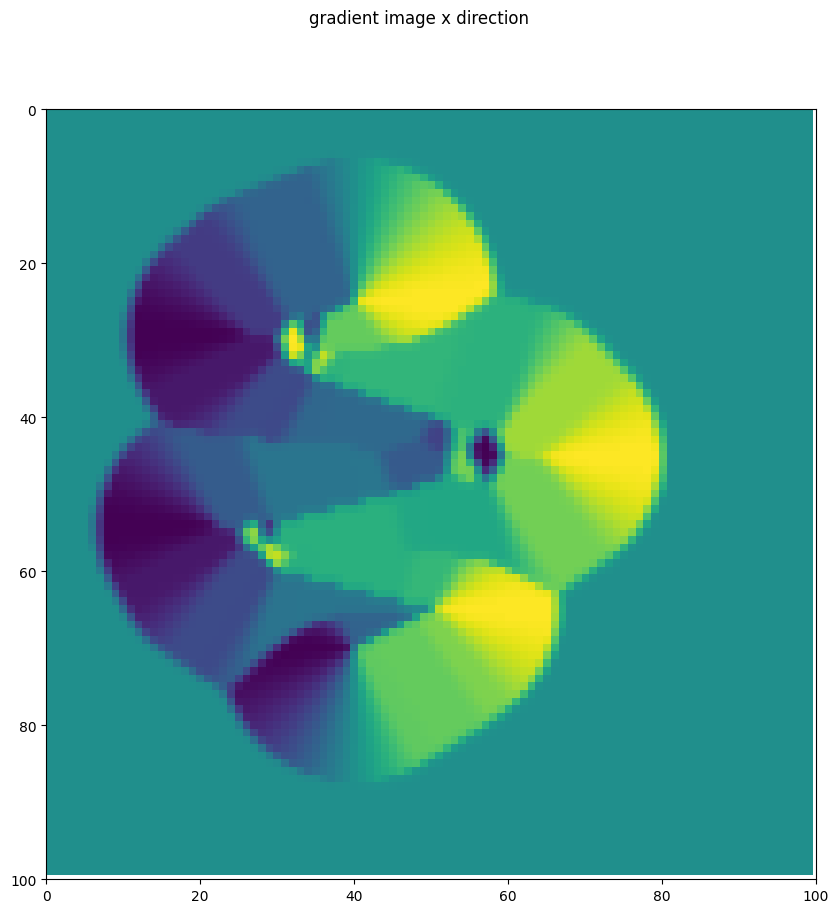

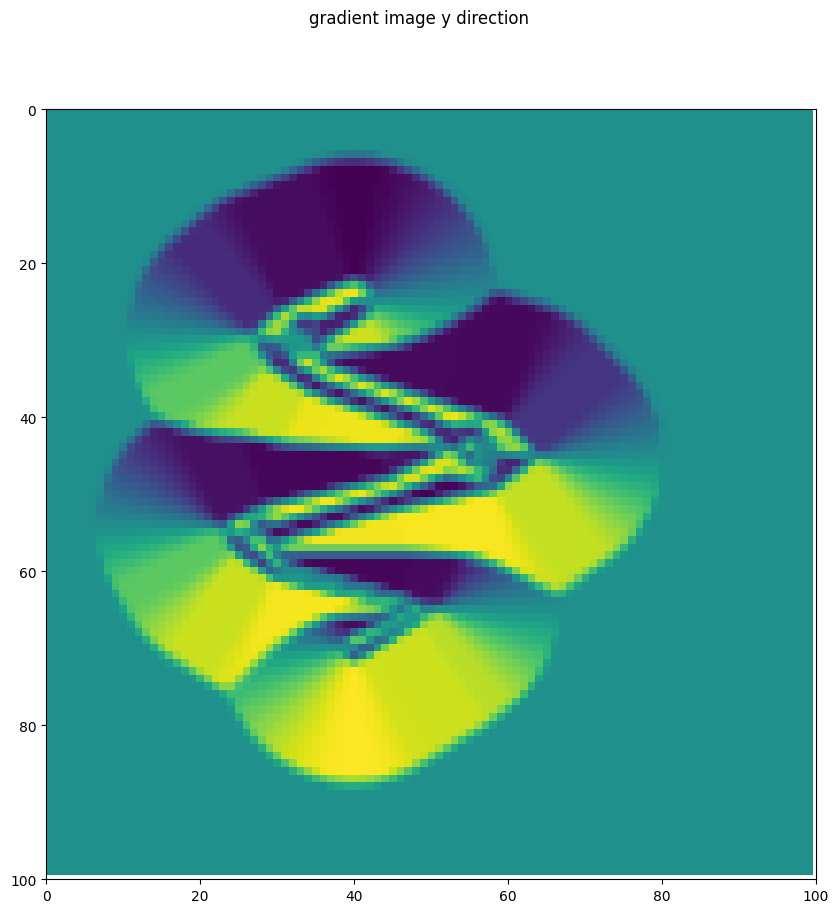

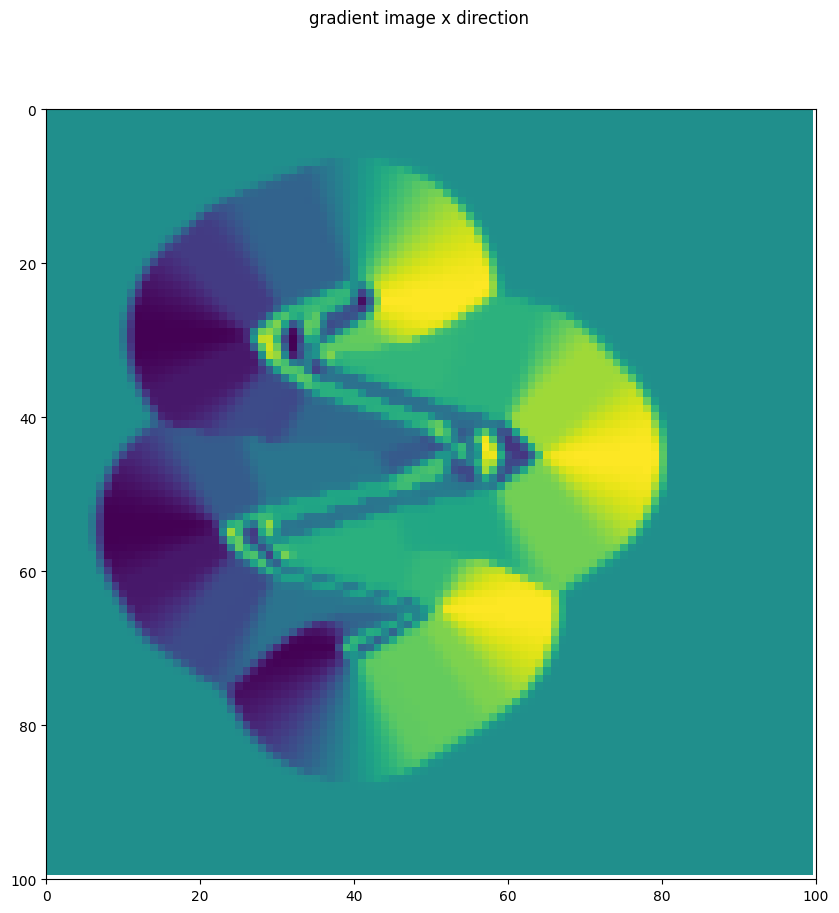

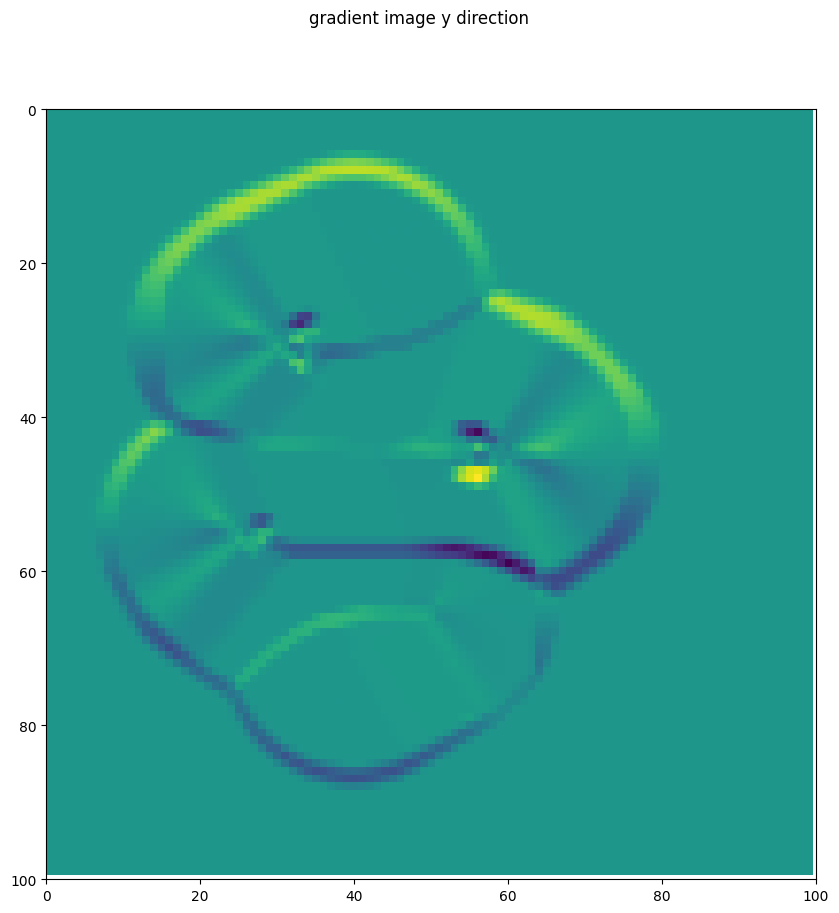

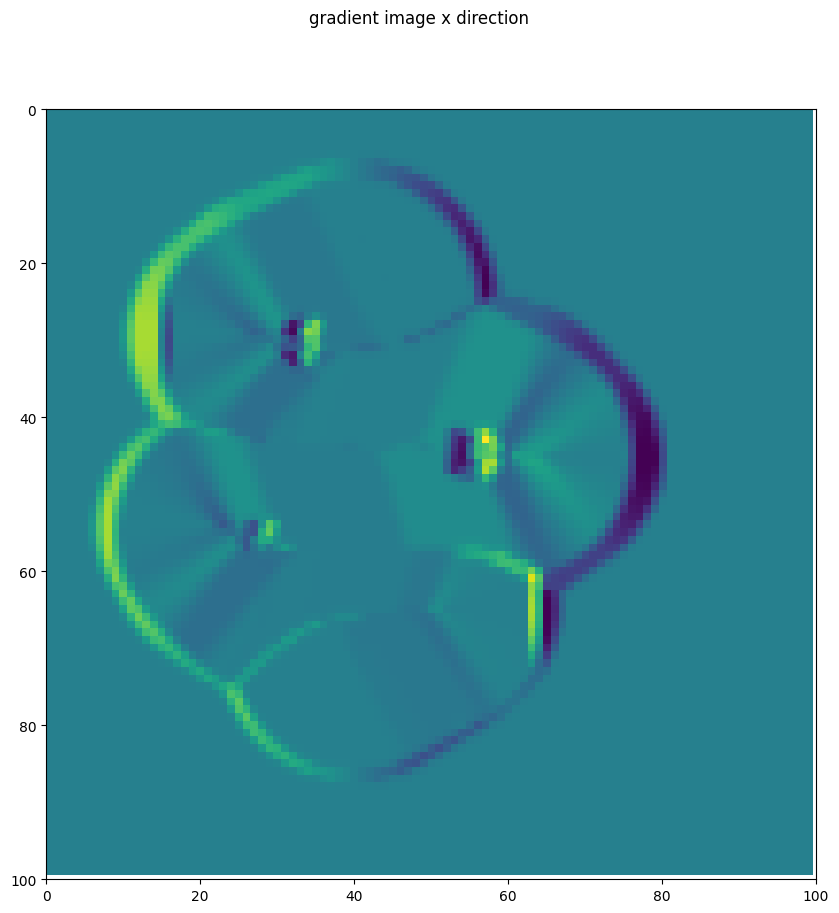

In [38]:
fltr = makeGaussEdgeFltr(0.5,2)
fltrtr = th.from_numpy(fltr).type(th.float32)

gimgV = cmptGradIm(predV,fltrtr)
gimgW = cmptGradIm(predW,fltrtr)
gimgdis = cmptGradIm(pred_dis,fltrtr)

extgradfac=1.0
gimgV = gimgV[0]
gimgW = gimgW[0]
gimgdis = gimgdis[0]
croprib=[slice(0,200), slice(0,200)]

show(gimgV[0].detach().numpy(),"gradient image y direction")
show(gimgV[1].detach().numpy(),"gradient image x direction")

show(gimgW[0].detach().numpy(),"gradient image y direction")
show(gimgW[1].detach().numpy(),"gradient image x direction")

show((gimgdis[0]-gimgV[0]).detach().numpy(),"gradient image y direction")
show((gimgdis[1]-gimgV[1]).detach().numpy(),"gradient image x direction")

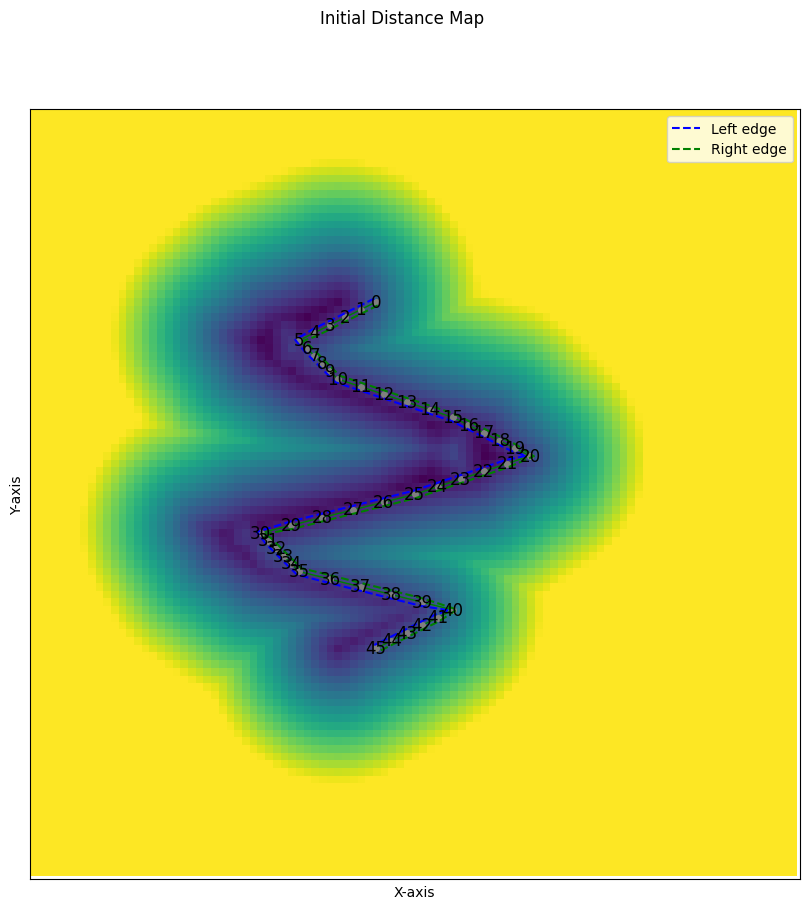

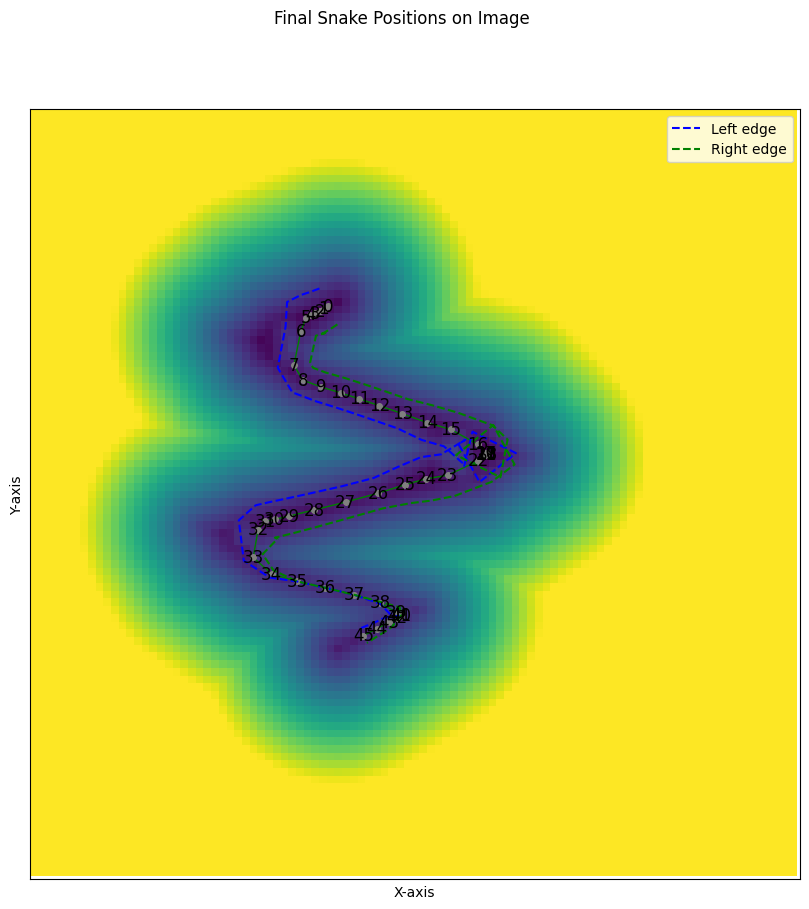

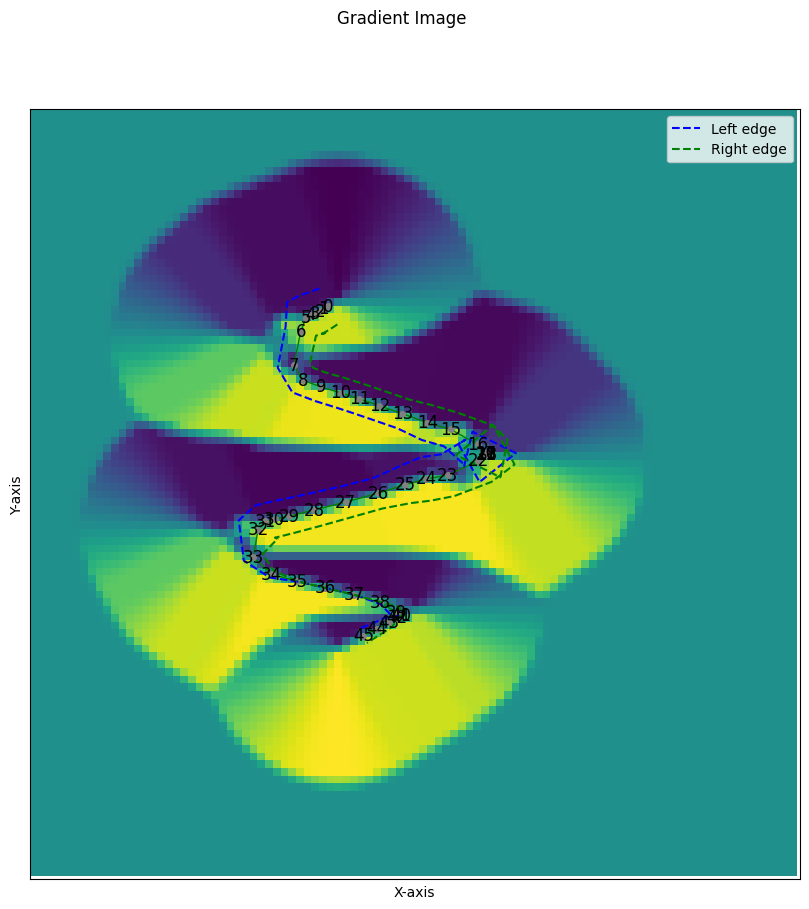

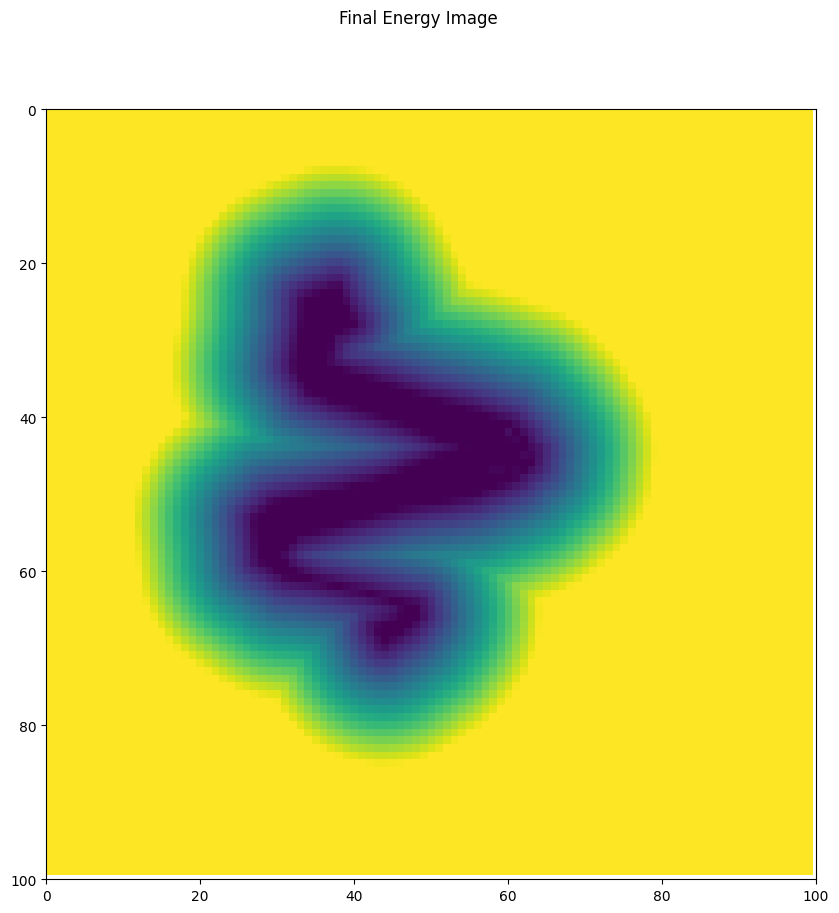

In [39]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimgV, gimgW, step_type="original")
#sb.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w * norms_prev / 2).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w * norms_prev / 2).detach().cpu().numpy()
showriba(predV[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(150)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(predV[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimgV[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)

gra = sb.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = sb.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))
dis_final = render_distance_map_2d1F(samples_to_widths, [100, 100], norms)
dis_final = torch.clamp(dis_final, max=16)

show(dis_final.detach().cpu().numpy(), 'Final Energy Image')

# Sine

In [34]:
from math import sin,pi

C:\Users\serta\AppData\Local\Temp\ipykernel_21196\930293430.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))


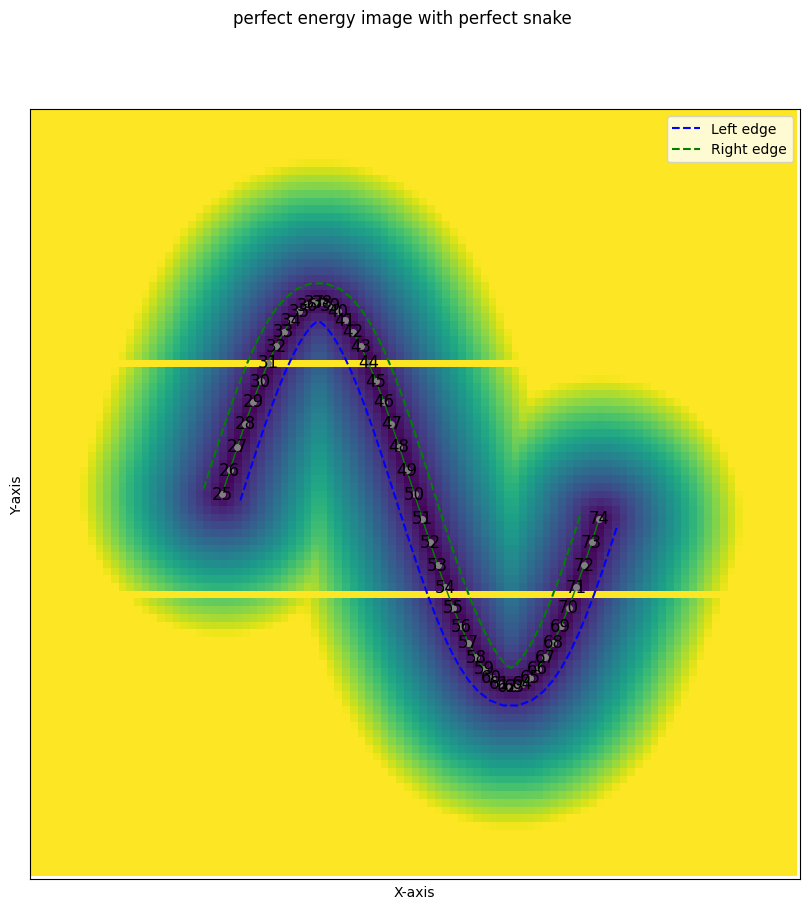

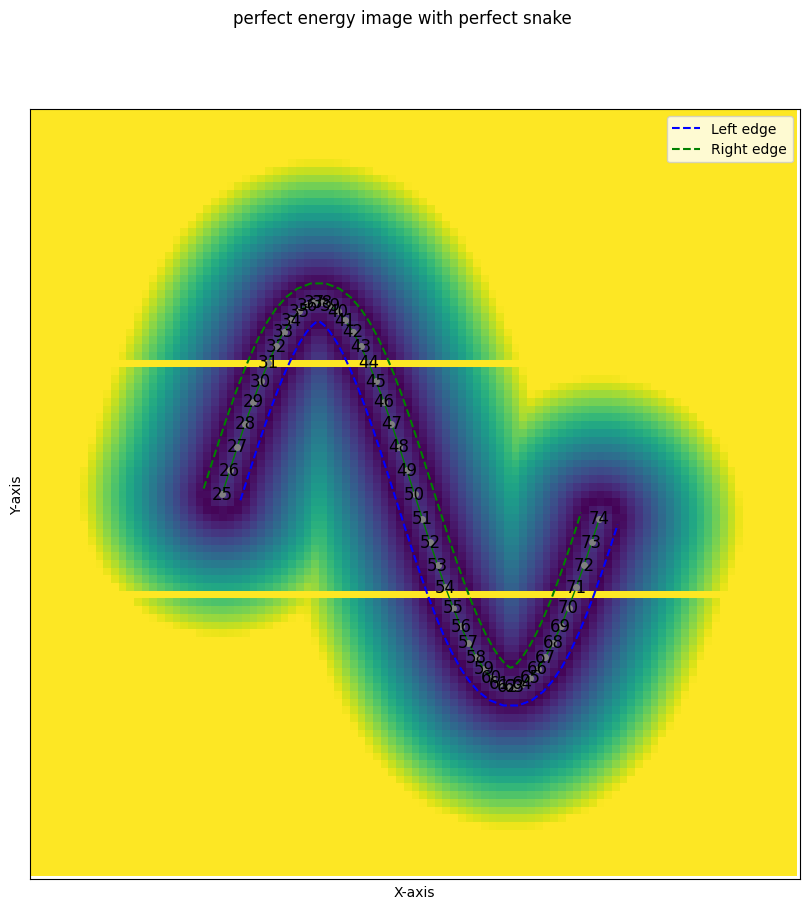

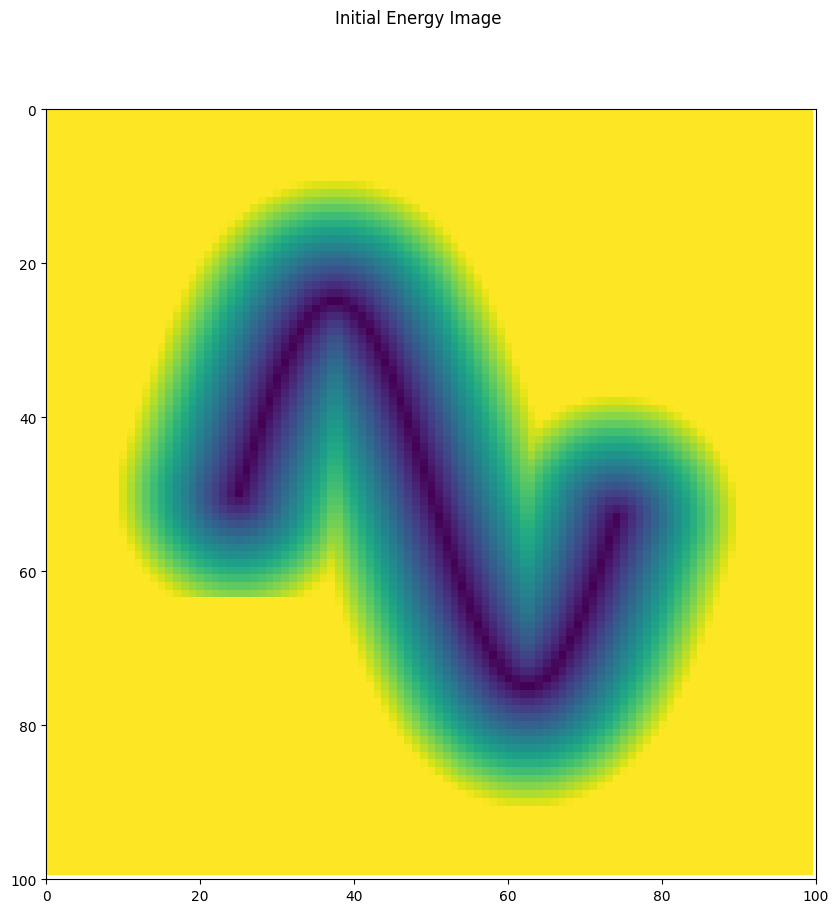

In [35]:
widths = th.tensor([5.0]*50,dtype=th.float32)
g=nx.Graph()
for i in range(25,75):
    g.add_node(i,pos=np.array([sin(i*2*pi/50.0)*25+50,i]))
    if i>25:
        g.add_edge(i,i-1)

stepsz = 0.33
alpha = 0.0001
beta = 0.1
crop = [slice(0, 200), slice(0, 200)]
ndims = 2

s = RibbonSnake(g, crop, stepsz, alpha, beta, None, None)
s.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))

gra = s.getGraph()
nodes = [gra.nodes[n]['pos'] for n in gra.nodes()]
widths = s.get_w().flatten()
samples_to_widths = list(zip(nodes, widths))

norms_perf = s._compute_normals_complex(s.s).numpy()
disV = dist_perfectV(samples_to_widths, [100, 100], norms_perf)
disV = torch.clamp(disV, max=16)
disW = torch.abs(disV)
disW[33:34,:] = 16.0
disW[63:64,:] = 16.0
disV[33:34,:] = 16.0
disV[63:64,:] = 16.0

v_L_perf = (s.s - s.w / 2.0 * norms_perf).detach().cpu().numpy()
v_R_perf = (s.s + s.w / 2.0 * norms_perf).detach().cpu().numpy()

showriba(disV.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)
showriba(disW.detach().cpu().numpy(), 'perfect energy image with perfect snake', gra, v_L_perf, v_R_perf)

size = [100, 100]
cropsz = [16, 16]
dmax = 16
maxedge = 4

dis = s.renderDistanceMap(size, cropsz, dmax, maxedge)
show(dis.detach().cpu().numpy(), 'Initial Energy Image')
pred = dis.clone()[None, None]

#del s

for n in g.nodes():
    g.nodes[n]["pos"]+=np.array([4,0])

pred_v = disV.clone()[None, None]
pred_w = disW.clone()[None, None]

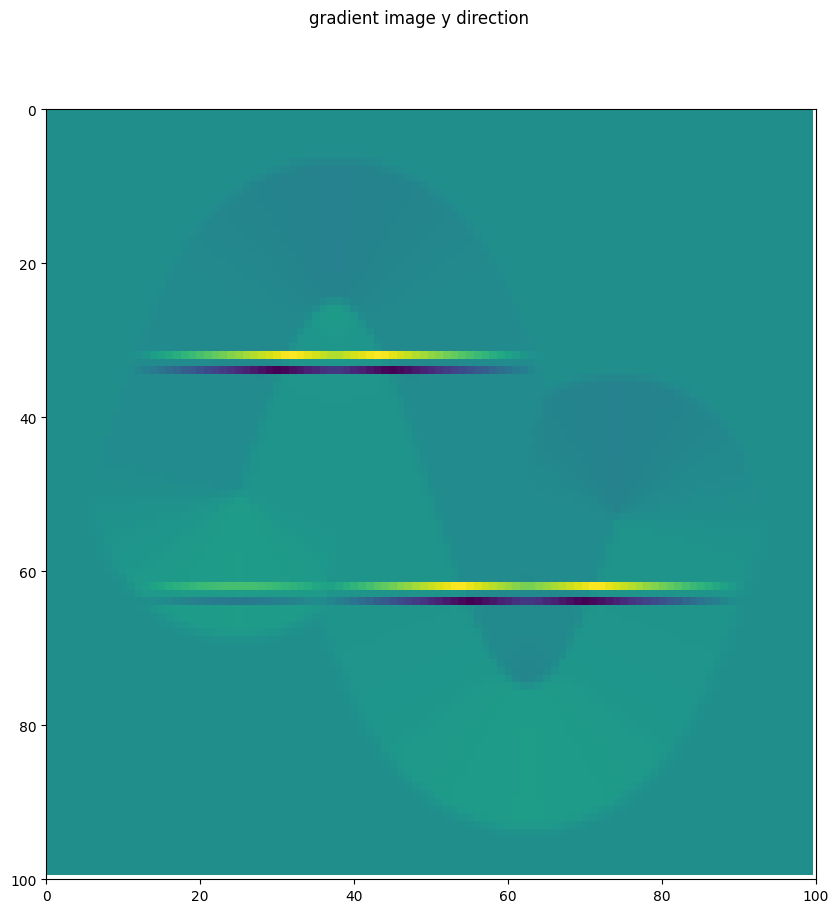

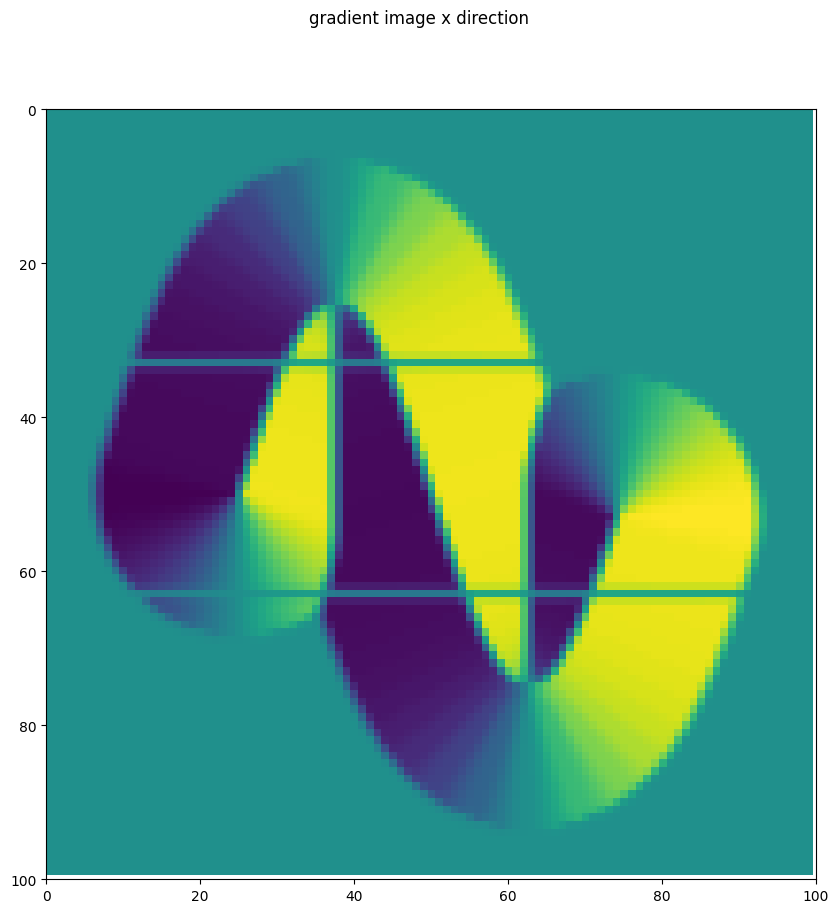

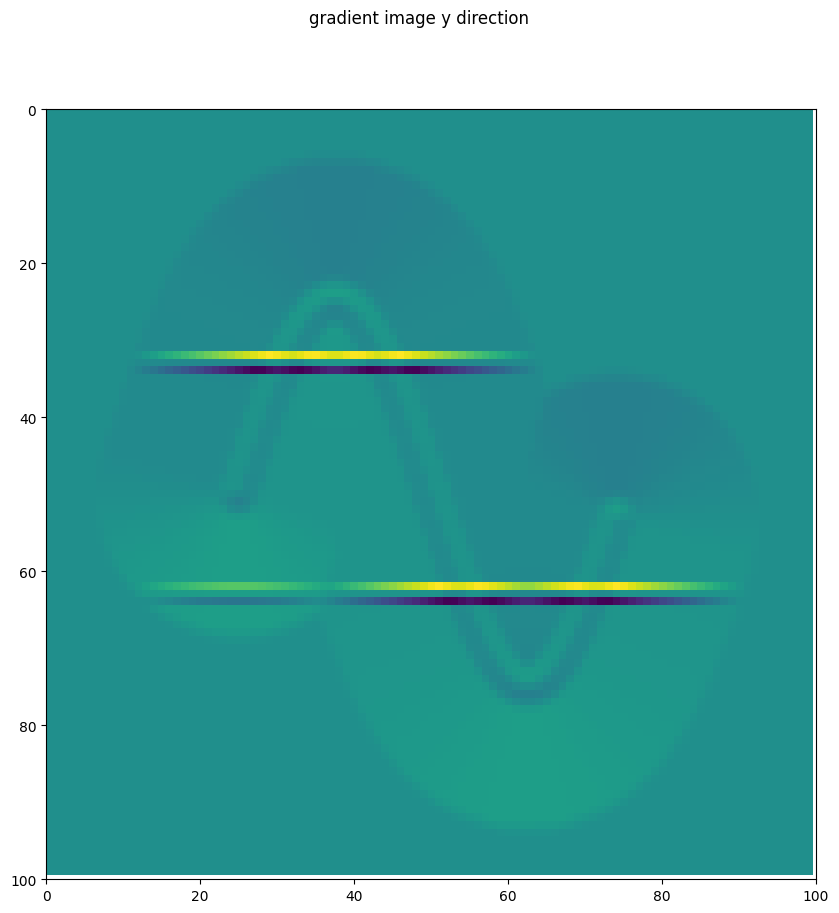

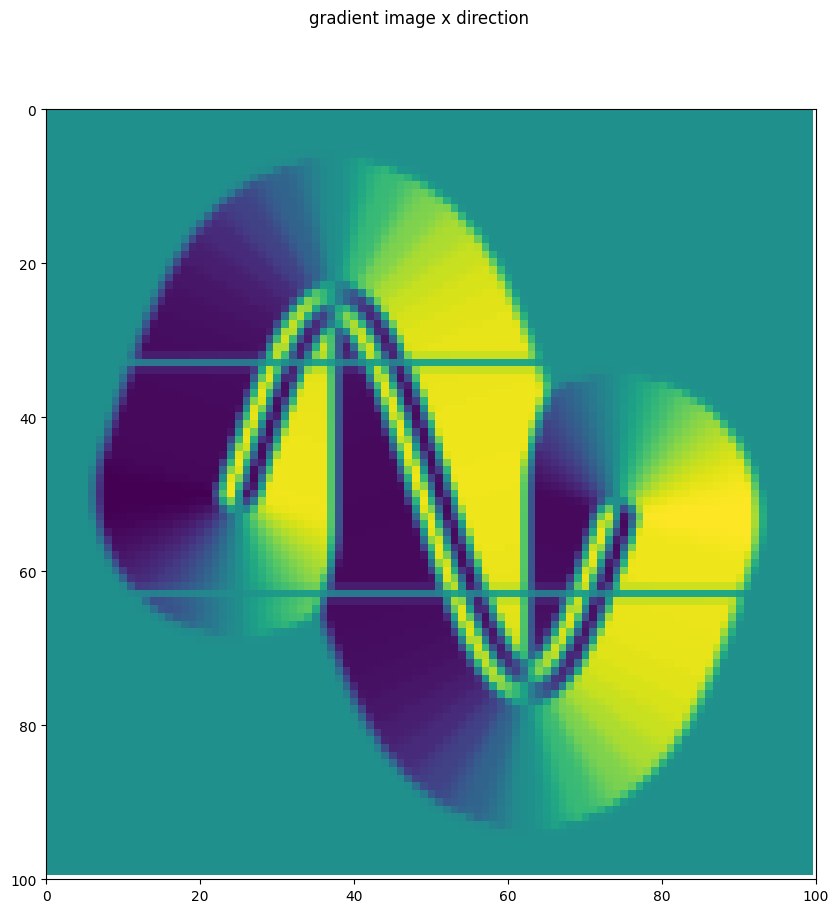

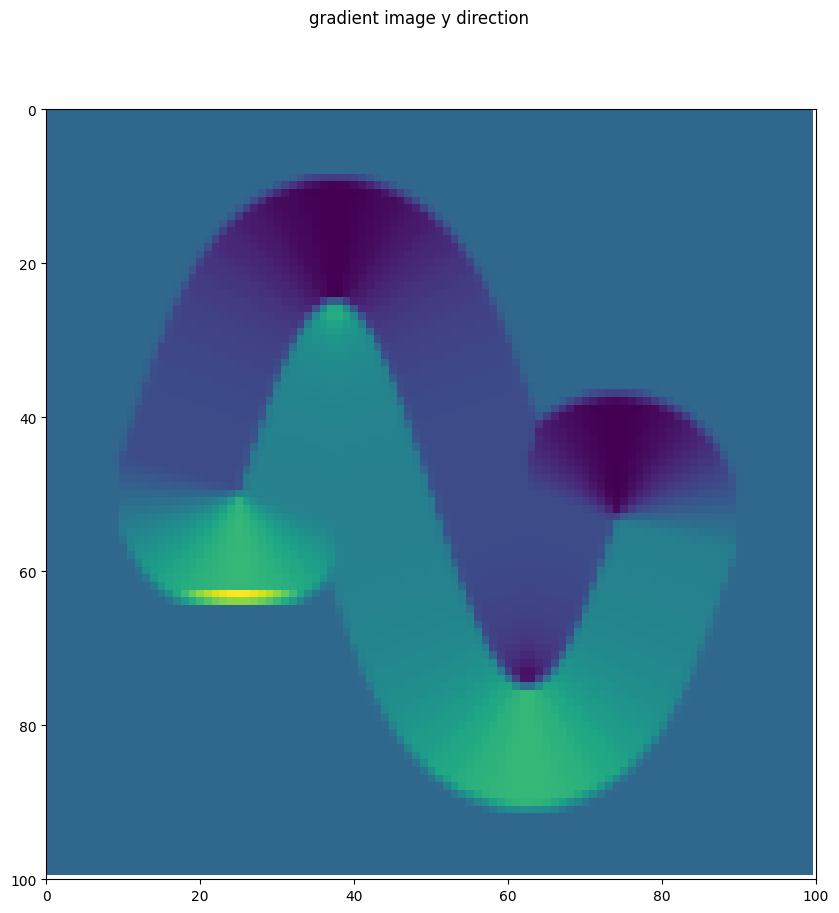

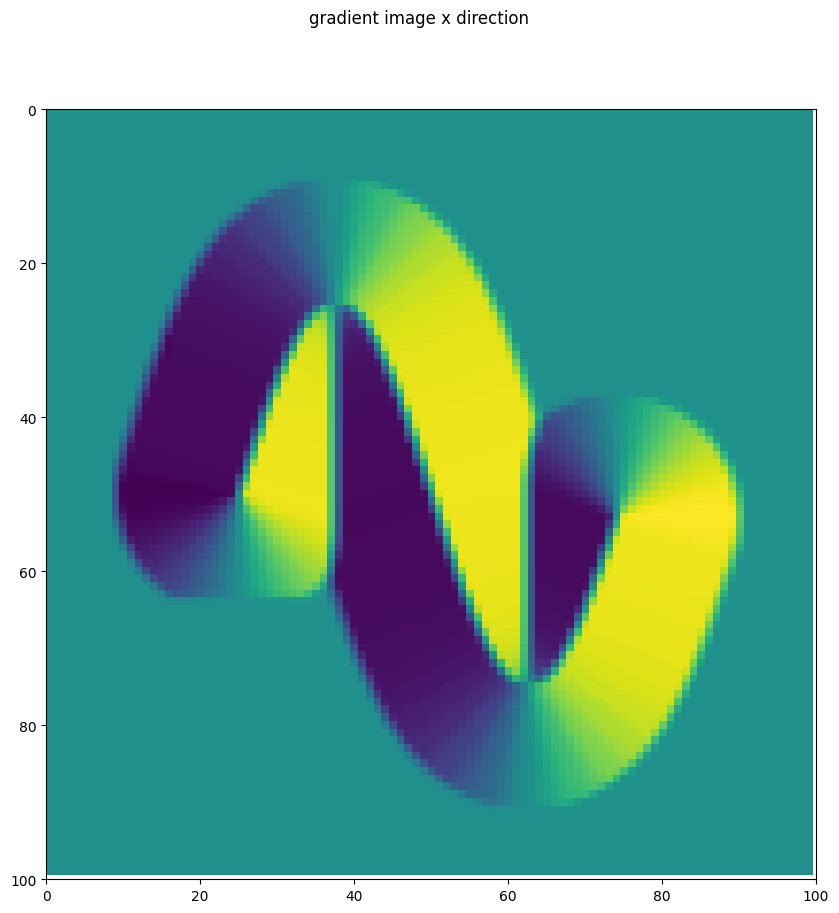

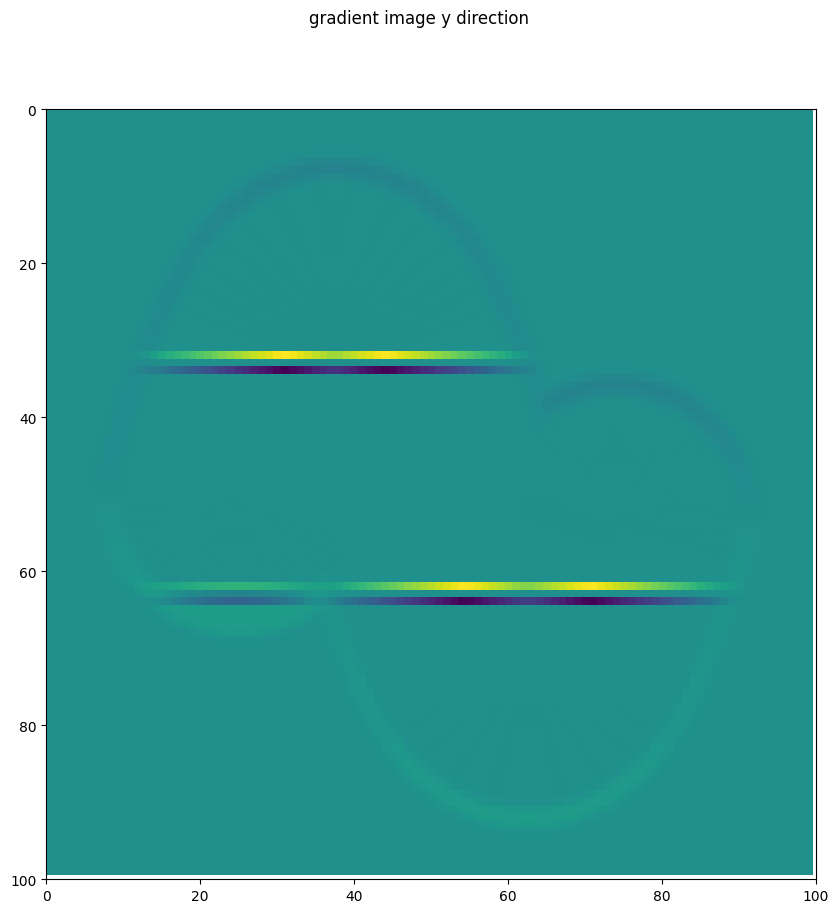

In [36]:
fltr = makeGaussEdgeFltr(0.5,2)
fltrtr = th.from_numpy(fltr).type(th.float32)
gimgv = cmptGradIm(pred_v,fltrtr)
gimgw = cmptGradIm(pred_w,fltrtr)

gimg = cmptGradIm(pred,fltrtr)

show(gimgv[0][0].detach().numpy(),"gradient image y direction")
show(gimgv[0][1].detach().numpy(),"gradient image x direction")

show(gimgw[0][0].detach().numpy(),"gradient image y direction")
show(gimgw[0][1].detach().numpy(),"gradient image x direction")

show(gimg[0][0].detach().numpy(),"gradient image y direction")
show(gimg[0][1].detach().numpy(),"gradient image x direction")

show(gimgv[0][0] - gimg[0][0],"gradient image y direction")

extgradfac=1.0
gimgv = gimgv[0]
gimgw = gimgw[0]
gimg = gimg[0]

croprib=[slice(0,200), slice(0,200)]

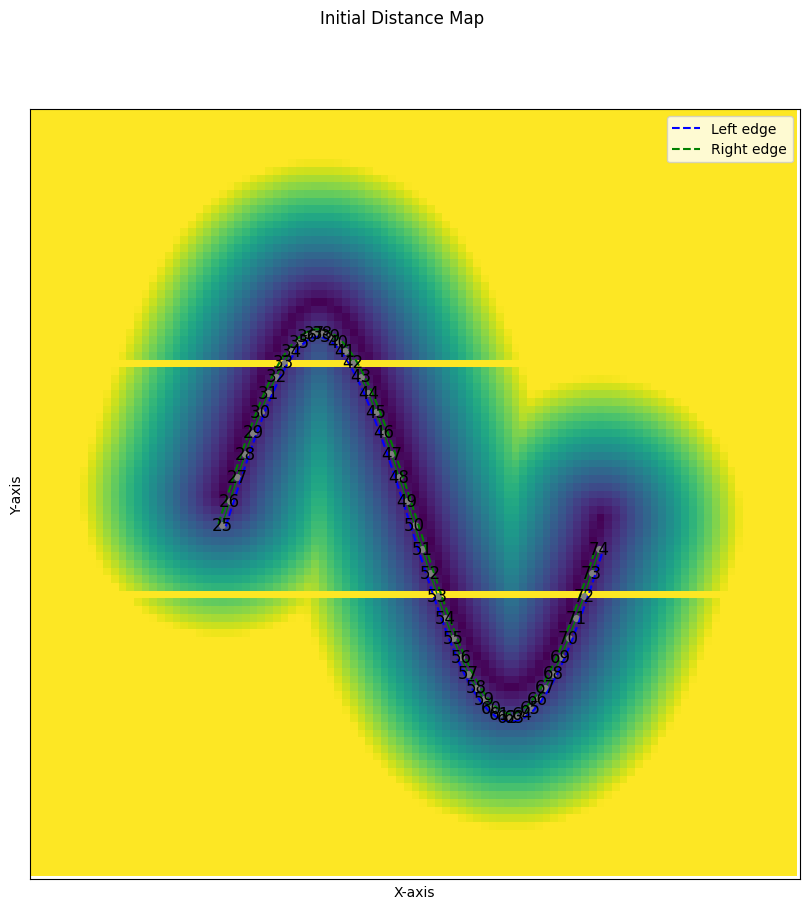

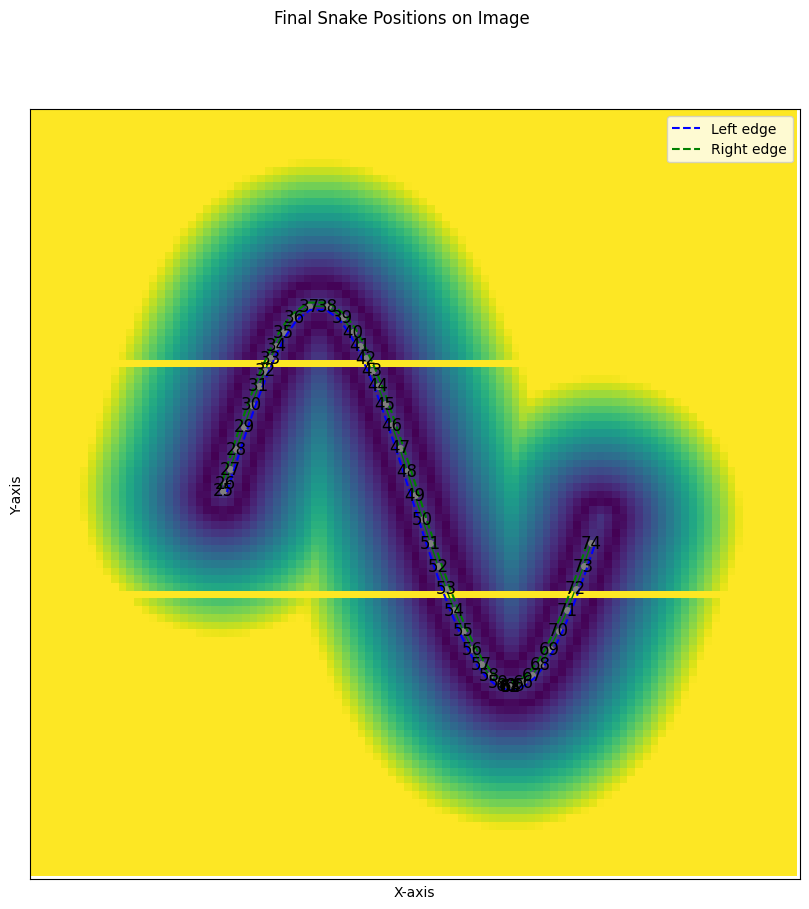

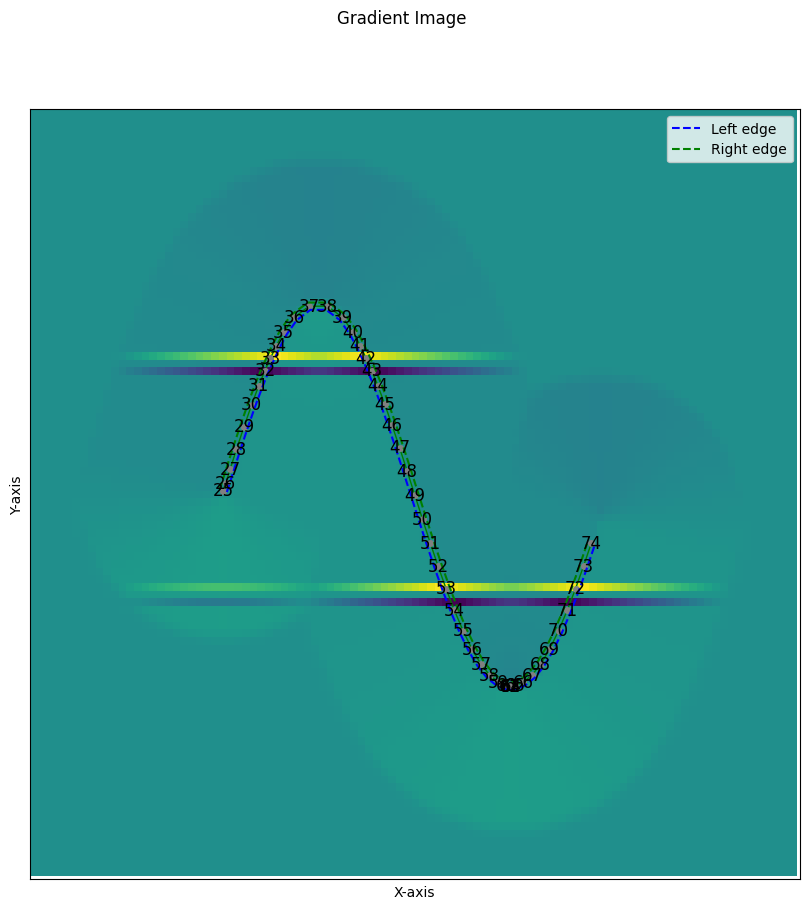

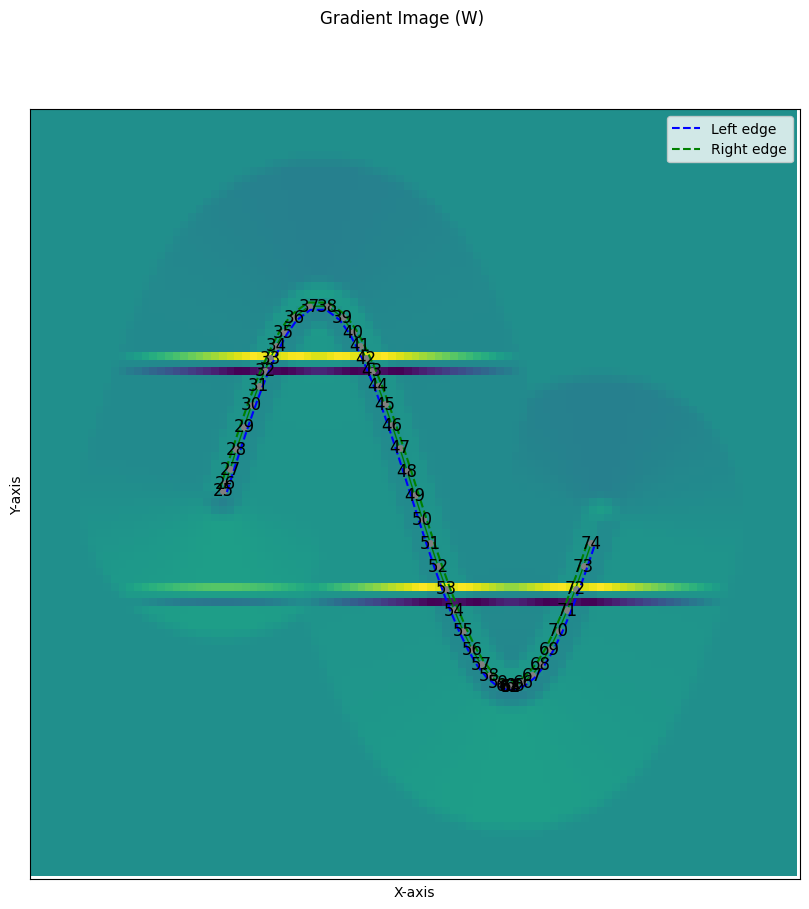

" gra_res = sb.getGraph()\nnodes_res = [gra_res.nodes[n]['pos'] for n in gra_res.nodes()]\nwidths_res = s.get_w().flatten()\nsamples_to_widths_res = list(zip(nodes_res, widths_res))\ndist_map_res = render_distance_map_2d1F(samples_to_widths_res, [100, 100], norms_prev)\ndist_map_res = torch.clamp(dist_map_res, max=16)\nshowriba(dist_map_res.detach().cpu().numpy(), 'Final Energy Image with Final Snake', gra_res) "

In [37]:
sb=RibbonSnake(g,croprib,stepsz,alpha,beta,gimg, gimgw, step_type="original")
#sb.set_w(th.tensor(widths, dtype=th.float32).view(-1, 1))
#print("Node positions: ", sa.s)
#print("Node widths: ",sa.w)
# Plot the image
norms_prev = sb._compute_normals_complex(sb.s)
v_L_prev = (sb.s - sb.w / 2.0 * norms_prev).detach().cpu().numpy()
v_R_prev = (sb.s + sb.w / 2.0 * norms_prev).detach().cpu().numpy()
showriba(pred_v[0, 0].detach().cpu().numpy(), 'Initial Distance Map', sb.getGraph(), v_L_prev, v_R_prev)

last = sb.optim(40)
#print("Node positions: ", sb.s)
#print("Node widths: ",sb.w)

# Get the final positions of the snake nodes
final_positions = sb.get_s().detach().cpu().numpy()
norms = sb._compute_normals_complex(sb.s)
v_L = (sb.s - sb.w * norms / 2).detach().cpu().numpy()
v_R = (sb.s + sb.w * norms / 2).detach().cpu().numpy()

# Plot the snake nodes
showriba(pred_w[0, 0].detach().cpu().numpy(), 'Final Snake Positions on Image', sb.getGraph(), v_L, v_R)
showriba(gimgv[0].detach().cpu().numpy(), 'Gradient Image', sb.getGraph(), v_L, v_R)
showriba(gimgw[0].detach().cpu().numpy(), 'Gradient Image (W)', sb.getGraph(), v_L, v_R)

""" gra_res = sb.getGraph()
nodes_res = [gra_res.nodes[n]['pos'] for n in gra_res.nodes()]
widths_res = s.get_w().flatten()
samples_to_widths_res = list(zip(nodes_res, widths_res))
dist_map_res = render_distance_map_2d1F(samples_to_widths_res, [100, 100], norms_prev)
dist_map_res = torch.clamp(dist_map_res, max=16)
showriba(dist_map_res.detach().cpu().numpy(), 'Final Energy Image with Final Snake', gra_res) """